In [1]:
%matplotlib inline
# import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import boost_histogram as bh
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

from lmfit.models import *
from lmfit import Model, Parameters

In [2]:
# read in reconstructed data
rec = pd.read_csv("rga_mPim_yields_01_02_2021.csv", index_col=False )
rec = rec[(rec.mm2_mPim.astype(float) > -0.4)]
rec = rec[(rec.mm2_mPim.astype(float) < 0.4)]
# rec = rec[(rec.pim_mom_mPim > 6)]
# rec = rec[(rec.pim_mom_mPim < 8)]


#rec['cos_theta'] = np.cos(rec.pip_theta).astype(np.float32)
rec.head()

w        q2  pim_mom_mPim  pim_theta_mPim  pim_phi_mPim  mm2_mPim  \
0  1.585307  1.691598      0.409746       15.490162     19.476534 -0.000799   
1  1.647999  3.875467      1.580817       26.787193     94.559654 -0.069337   
2  2.193610  2.332619      1.590619        9.358319    334.442963 -0.007958   
7  2.505944  2.596223      1.633323       46.574902    318.433716  0.161336   
9  2.373577  2.751077      1.581435       31.623615    210.872742  0.296708   

         weight  
0 -8.183079e-12  
1 -8.183079e-12  
2 -8.183079e-12  
7 -8.183079e-12  
9 -8.183079e-12

No handles with labels found to put in legend.


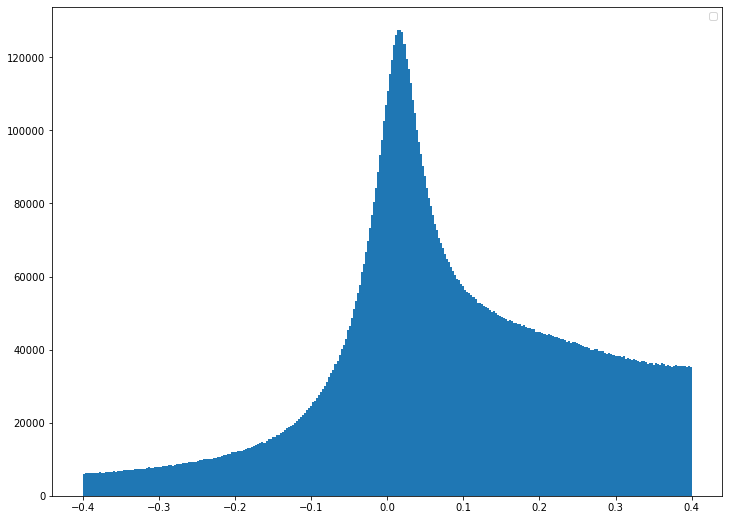

In [3]:

# plot W histogram

# Make a figure and axes to plot on
fig, ax = plt.subplots(figsize=(12,9))

#Plot hist on axes
# ax.hist(rec.mm2_mPim, bins=1, alpha=0.5, label='data', density=False, )
ax.hist(rec.mm2_mPim.to_numpy(),bins=300, range=(-0.4,0.4), density=False)
# put legend on axes
ax.legend()
# plt.xlim(-0.4, 0.4)

# Show figure
fig.show()

In [12]:
# Create function to
import sys
from scipy import integrate

def mm_cut(df):
#     a = 0.0
    NSIGMA = 4
    cut_data = {}
#              s = str(mom_val)+'-'+str(mom_val+1)+'(GeV)''\u03B8 = (' + str(theta_val*18)+"-"+ str((theta_val+1)*18) +')\u00B0 and '+"\u03C6 = ("+str(phi_val*120)+'-'+str((phi_val+1)*120)+')\u00B0'
    # Seclect the data for the sector

    # Make a figure to plot on
    plt.figure(figsize=(12,9))
    # Histogram the data and 
    y, x = np.histogram( df.mm2_mPim.to_numpy(), 
                                 bins=150, range=(-0.4,0.4), density=False)
    # here y, x is written because it plot the output as the x and y coordinates on a linegraph.
   
    # calculate bin centers
    x=(x[1:]+x[:-1])/2
#     print(x, y)
    # Plot points on
    plt.errorbar(x,y,yerr=stats.sem(y), fmt='.', zorder=1)
    # Make a model with a peak
    peak = BreitWignerModel(prefix="peak_")
    pars = peak.make_params()
    # Set some parameters
    pars['peak_center'].set(value=0.014, min=-0.01, max=0.02)
#     pars['peak_sigma'].set(value=0.05, min=0.0, max=0.1)
#     pars['peak_amplitude'].set(value=12000) 
    
    # Set the background
    background = PolynomialModel(2, prefix="back_")
#     pars_back = background.make_params()
#     pars_back['pars_back_c0'].set(value=0.1,min=0.)
    
    pars.update(background.guess(y, x=x))
    pars['back_c0'].set(value=0.1,min=0.)
#     print(pars)
                # Make full model to fit
    model = peak + background
        
                # Fit our full model
    out = model.fit(y, pars, x=x)

                # Make a more fine set of x's to plot with
    xs= np.linspace(-0.4, 0.4, 150)
#     print(xs, y) 
                # Plot our output model withe the new parameter and finer x's
    plt.plot(xs, out.eval(params=out.params, x=xs), label='Total Fit')
#     print(y, out.eval(x=xs))
                # Get the components of the fit for our finer x's
    comps = out.eval_components(x=xs)
#     print(comps['peak_'])
                # Plot just the peak component
    plt.plot(xs, comps['peak_'], 
                    'g-', label=f"Peak Fit: center = {out.params['peak_center'].value:0.2f}, sigma = {out.params['peak_sigma'].value:0.2f},")

    plt.plot(xs, comps['back_'], 'r-',
                    label=f"Background Fit : back_c0 = {out.params['back_c0'].value:0.2f}")
#                 Plot center +- sigma where we will cut later
    plt.axvline(out.params['peak_center']-NSIGMA*out.params['peak_sigma'])
    plt.axvline(out.params['peak_center']+NSIGMA*out.params['peak_sigma'])
        
                # Put on labels and show the plot
#                 plt.text(1, 1, 'phi_val = %1f ' % (phi_val))
#                 plt.text(0.5, 0.5, 'theta_val = %1f' % (theta_val))
    plt.title("MMSQ")
    xs=np.linspace(-0.06, 0.08, num = 27) # , retstep = True
    comps1 = out.eval_components(x=xs)
    total = integrate.simps(out.eval(x=xs))
    peak_out = integrate.simps(comps1['peak_'])
    background_out = integrate.simps(comps1['back_'])
    
#                 f = background # lambda x:exp(-x**2)
#                 TotalInt = intg.quad(f, -0.1, 0.11)
#     a +=out.eval(x=xs)
#     help(model.fit)
#     help(background.fit)
    print('total = ', total)
    print('signal = ', peak_out)
    print('background = ', background_out)
    print('ratio = ', peak_out/background_out)
#     print(out.eval(x=xs))

    print(out.fit_report(min_correl=0.5))
    plt.xlabel('MMSQ (GeV)')
#             plt.ylabel('Y')
    plt.legend()
    plt.show()
        
# Save cut data to our
    cut_data = (out.params['peak_center']-NSIGMA*out.params['peak_sigma'], 
            out.params['peak_center']+NSIGMA*out.params['peak_sigma'])
        
            
        

    return cut_data

total =  4441233.099275772
signal =  3233726.8351483243
background =  1207506.2641274484
ratio =  2.6780207533623317
[[Model]]
    (Model(breit_wigner, prefix='peak_') + Model(polynomial, prefix='back_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 461
    # data points      = 150
    # variables        = 7
    chi-square         = 2.7526e+09
    reduced chi-square = 19248779.6
    Akaike info crit   = 2522.77513
    Bayesian info crit = 2543.84958
[[Variables]]
    peak_amplitude:  5718.02669 +/- 530.588277 (9.28%) (init = 1)
    peak_center:     0.00595661 +/- 7.4286e-04 (12.47%) (init = 0.014)
    peak_sigma:      0.08739492 +/- 0.00160343 (1.83%) (init = 1)
    peak_q:          5.77789935 +/- 0.27672870 (4.79%) (init = 1)
    back_c0:         45912.9340 +/- 1091.26543 (2.38%) (init = 0.1)
    back_c1:         69073.6549 +/- 2360.60066 (3.42%) (init = 117614.8)
    back_c2:        -92954.9684 +/- 11537.0645 (12.41%) (init = -647508.1)
[[Correlations]

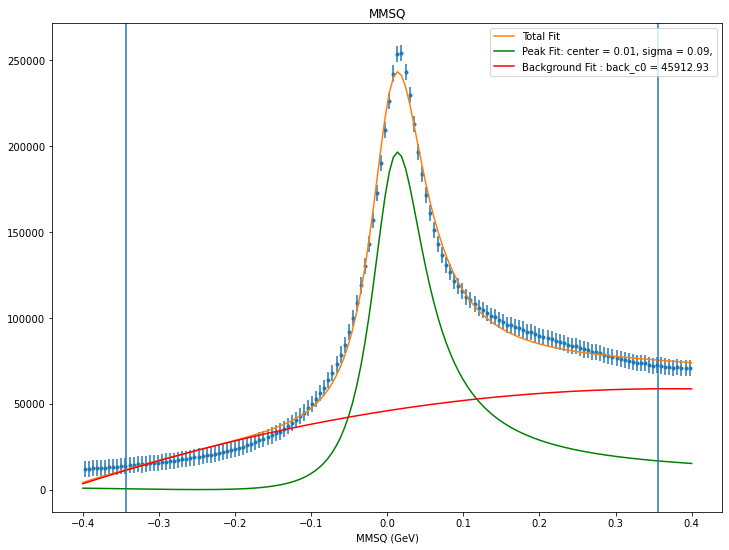

In [13]:
sector_cuts = mm_cut(rec)

In [16]:
# Create function to
import sys
from scipy import integrate
import csv

def mm_cut(df):
    with open('out_file_mPim.csv', mode='w') as out_file:
        out_mPim_writer = csv.writer(out_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        out_mPim_writer.writerow(['w (GeV)','total' ,'signal', 'background', 'ratio'])

    #     a = 0.0
        NSIGMA = 4
        cut_data = {}
        # Makes a list from 0 to 10 spaced by 1
        w_bin_ranges = np.arange(1.0,4.2, 0.05)
#       np.arange(0,10., 5.0)
       # Cuts the mom data into the ranges from above
        rec['w_bin'] = pd.cut(rec.w, w_bin_ranges)
        unique_w = rec.w_bin.unique()
        for w in unique_w:
            data = rec[rec.w_bin == w]
            s = f'MMSQ W = {w} GeV'

        #              s = str(mom_val)+'-'+str(mom_val+1)+'(GeV)''\u03B8 = (' + str(theta_val*18)+"-"+ str((theta_val+1)*18) +')\u00B0 and '+"\u03C6 = ("+str(phi_val*120)+'-'+str((phi_val+1)*120)+')\u00B0'
            # Seclect the data for the sector

            # Make a figure to plot on
            plt.figure(figsize=(12,9))
            # Histogram the data and 
            y, x = np.histogram( data.mm2_mPim.to_numpy(), 
                                         bins=150, range=(-0.4,0.4), density=False)
            # here y, x is written because it plot the output as the x and y coordinates on a linegraph.

            # calculate bin centers
            x=(x[1:]+x[:-1])/2
        #     print(x, y)
            # Plot points on
            plt.errorbar(x,y,yerr=stats.sem(y), fmt='.', zorder=1)
            # Make a model with a peak
            peak = BreitWignerModel(prefix="peak_")
            pars = peak.make_params()
            # Set some parameters
            pars['peak_center'].set(value=0.0, min=-0.01, max=0.02)
        #     pars['peak_sigma'].set(value=0.05, min=0.0, max=0.1)
            #pars['peak_amplitude'].set(value=0.5) 

            # Set the background
            background = PolynomialModel(2, prefix="back_")
        #     pars_back = background.make_params()
        #     pars_back['pars_back_c0'].set(value=0.1,min=0.)

            pars.update(background.guess(y, x=x))
            pars['back_c0'].set(value=0.1,min=0.)
        #     print(pars)
                        # Make full model to fit
            model = peak + background

                        # Fit our full model
            out = model.fit(y, pars, x=x)

                        # Make a more fine set of x's to plot with
            xs= np.linspace(-0.4, 0.4, 150)
        #     print(xs, y) 
                        # Plot our output model withe the new parameter and finer x's
            plt.plot(xs, out.eval(params=out.params, x=xs), label='Total Fit')
        #     print(y, out.eval(x=xs))
                        # Get the components of the fit for our finer x's
            comps = out.eval_components(x=xs)
        #     print(comps['peak_'])
                        # Plot just the peak component
            plt.plot(xs, comps['peak_'], 
                            'g-', label=f"Peak Fit: center = {out.params['peak_center'].value:0.2f}, sigma = {out.params['peak_sigma'].value:0.2f},")

            plt.plot(xs, comps['back_'], 'r-',
                            label=f"Background Fit : back_c0 = {out.params['back_c0'].value:0.2f}")
        #                 Plot center +- sigma where we will cut later
#             plt.axvline(out.params['peak_center']-NSIGMA*out.params['peak_sigma'])
#             plt.axvline(out.params['peak_center']+NSIGMA*out.params['peak_sigma'])
            plt.axvline(-0.06,)
            plt.axvline(0.08,)
                        # Put on labels and show the plot
        #                 plt.text(1, 1, 'phi_val = %1f ' % (phi_val))
        #                 plt.text(0.5, 0.5, 'theta_val = %1f' % (theta_val))
            plt.title(s)
            xs=np.linspace(-0.06, 0.08, num = 27) # , retstep = True
            comps1 = out.eval_components(x=xs)
            total = integrate.simps(out.eval(x=xs))
            peak_out = integrate.simps(comps1['peak_'])
            background_out = integrate.simps(comps1['back_'])

        #                 f = background # lambda x:exp(-x**2)
        #                 TotalInt = intg.quad(f, -0.1, 0.11)
        #     a +=out.eval(x=xs)
        #     help(model.fit)
        #     help(background.fit)
            out_mPim_writer.writerow([w,int(total) ,int(peak_out), int(background_out), "{:.2f}".format(peak_out/background_out)])
    #         print(int(total),',' ,int(peak_out),',' , int(background_out),',', "{:.2f}".format(peak_out/background_out))
        #     print('signal = ', peak_out.value)
        #     print('background = ', background_out)
        #     print('ratio = ', (peak_out/background_out))
        #     print(out.eval(x=xs))

#             print(out.fit_report(min_correl=0.5))
            plt.xlabel('MMSQ (GeV)')
        #             plt.ylabel('Y')
            plt.legend()
            plt.show()
        # Save cut data to our
            cut_data = (out.params['peak_center']-NSIGMA*out.params['peak_sigma'], 
                    out.params['peak_center']+NSIGMA*out.params['peak_sigma'])

    return cut_data

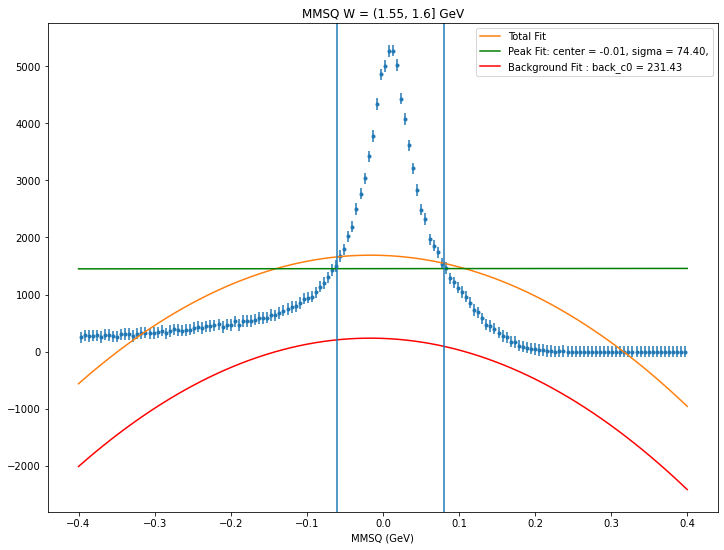

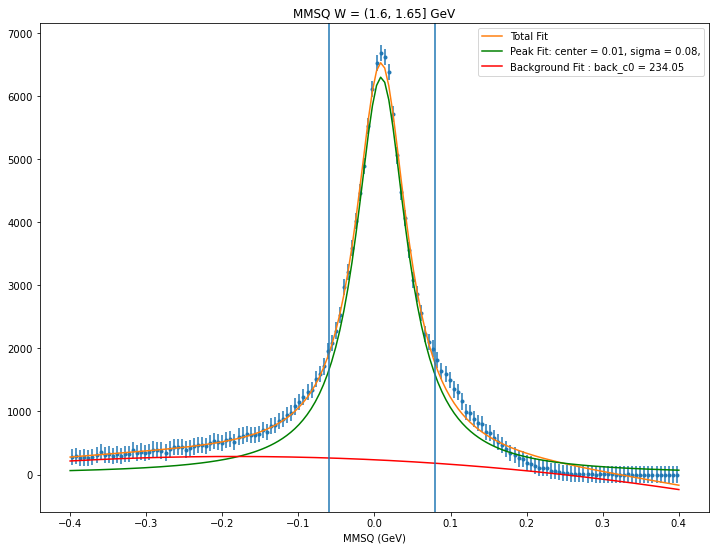

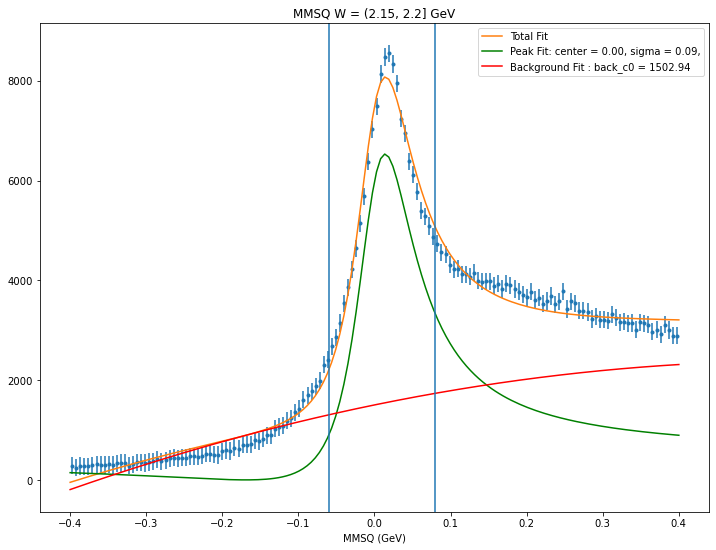

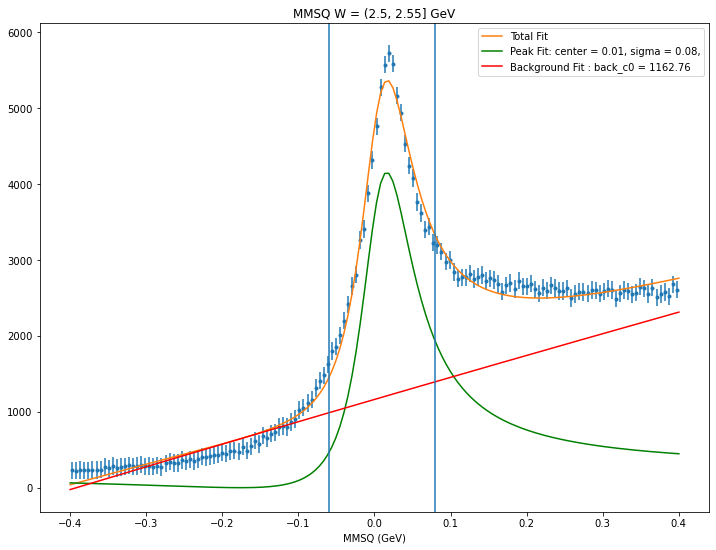

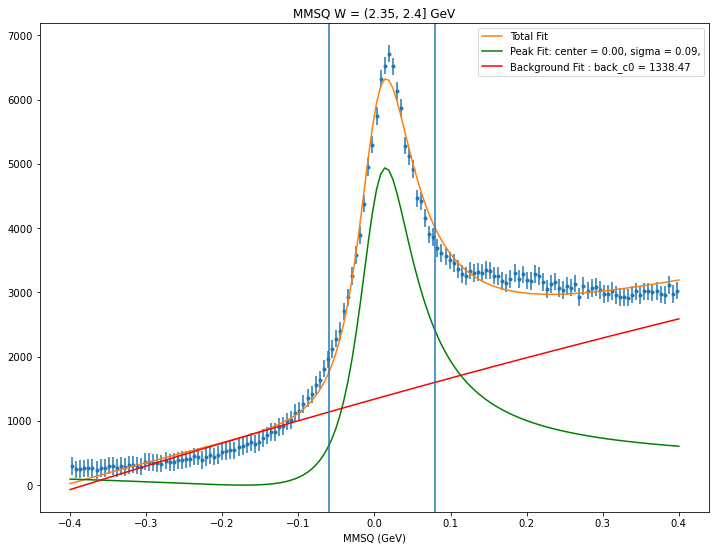

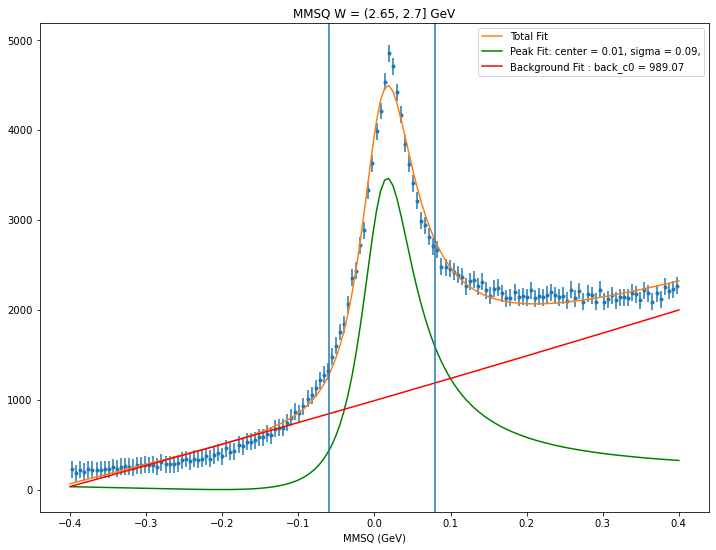

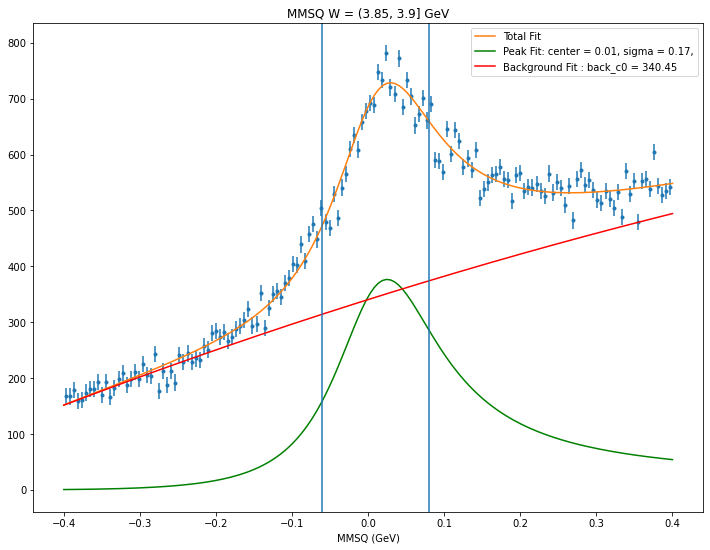

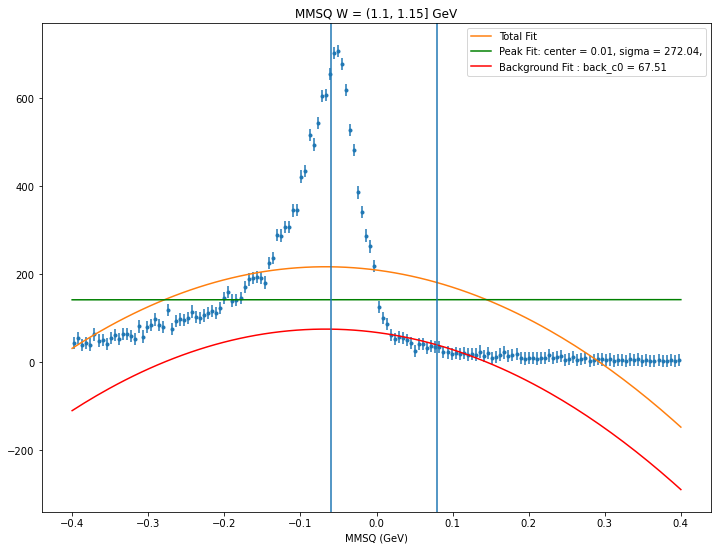

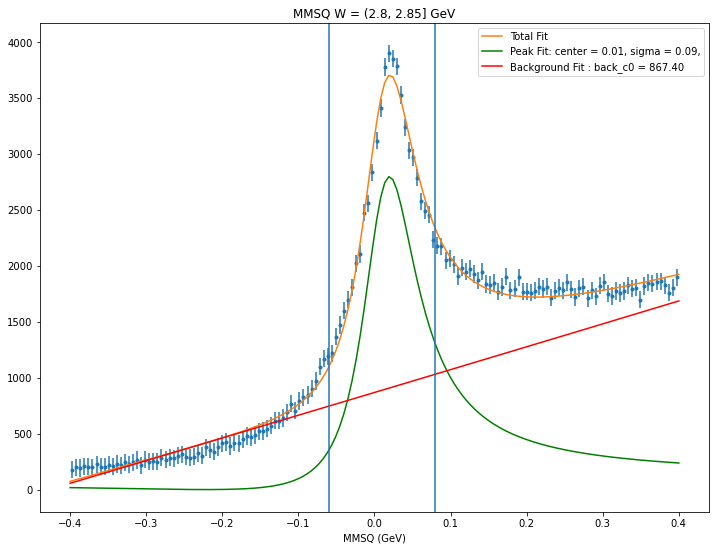

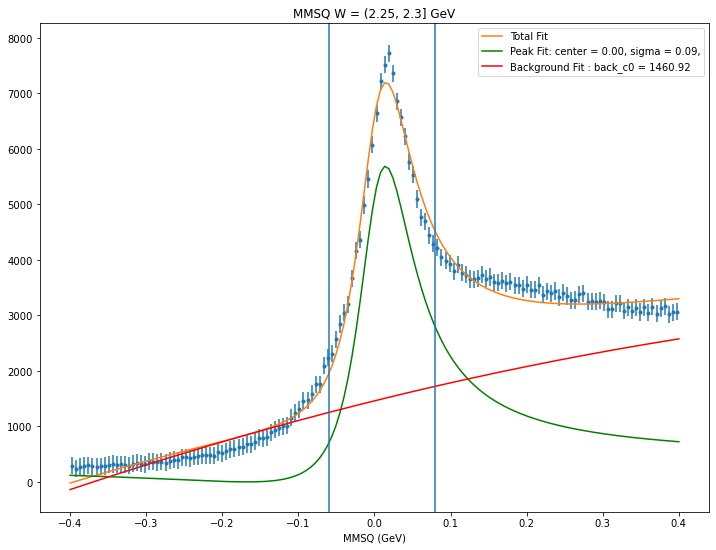

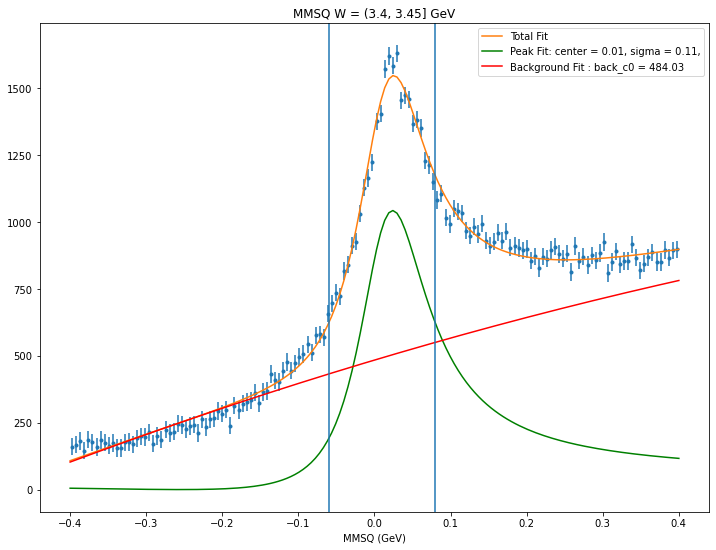

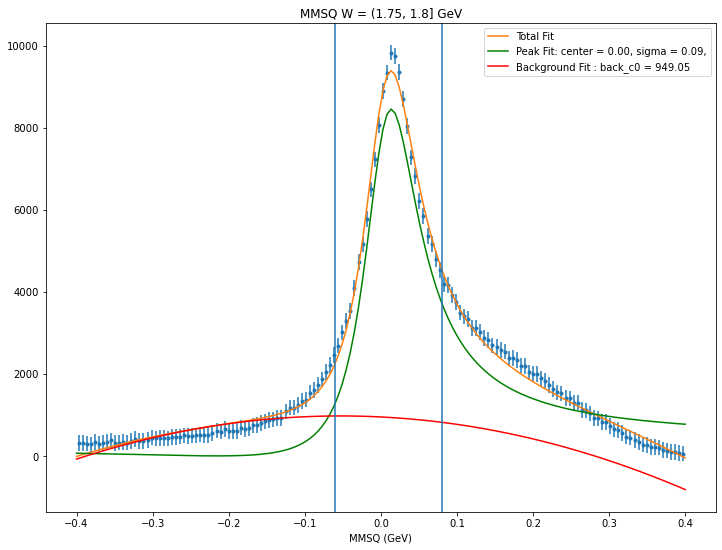

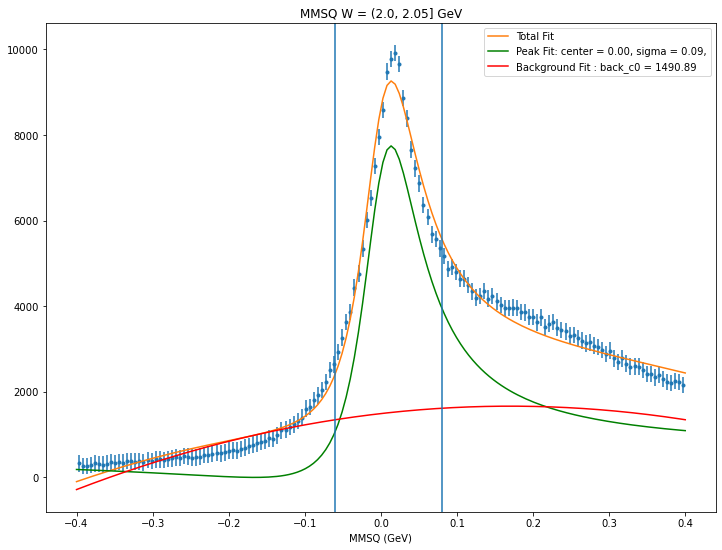

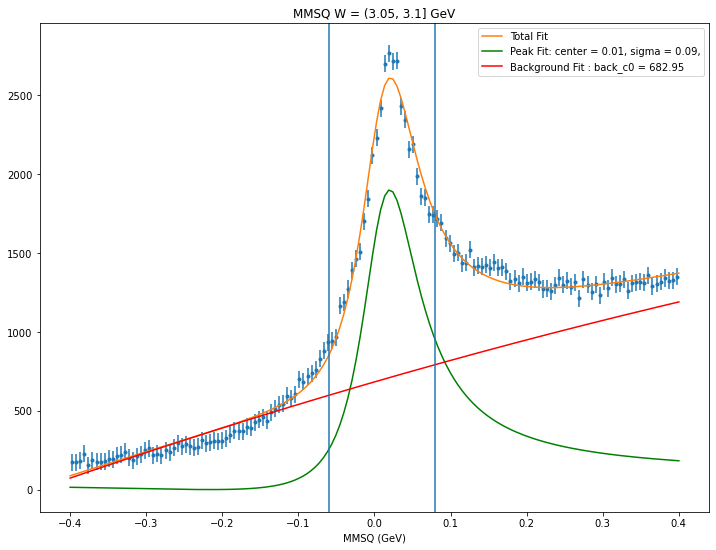

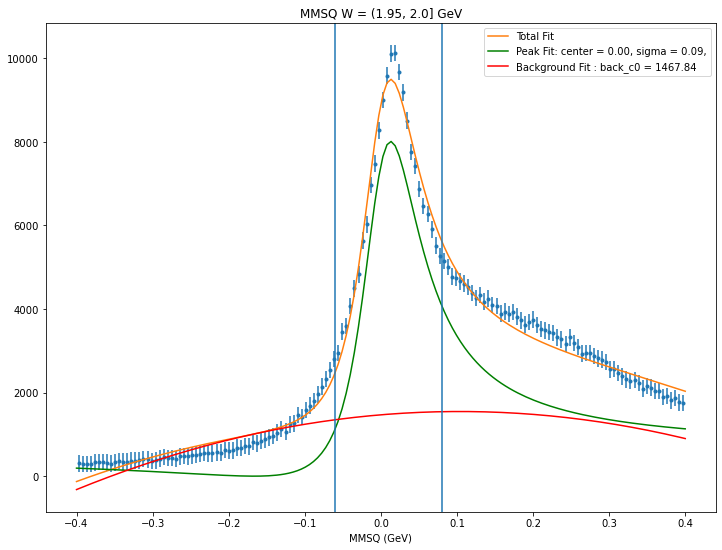

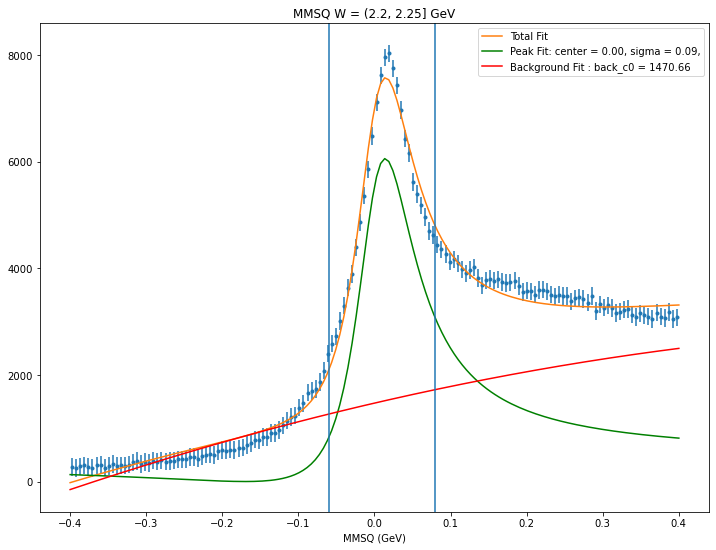

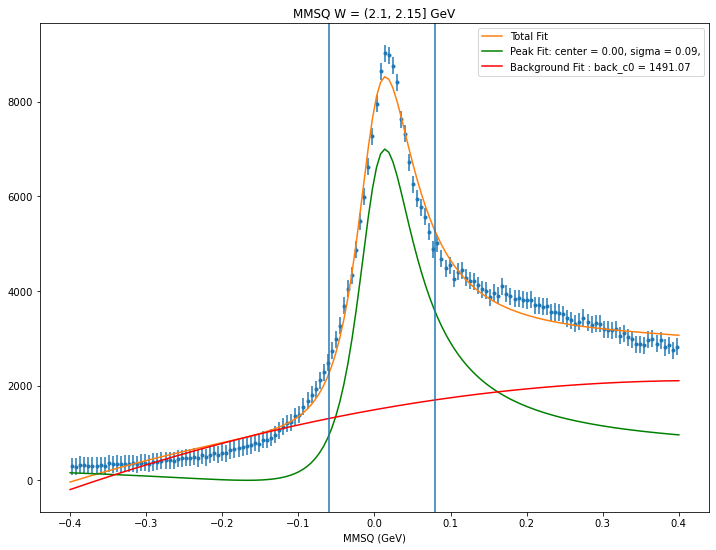

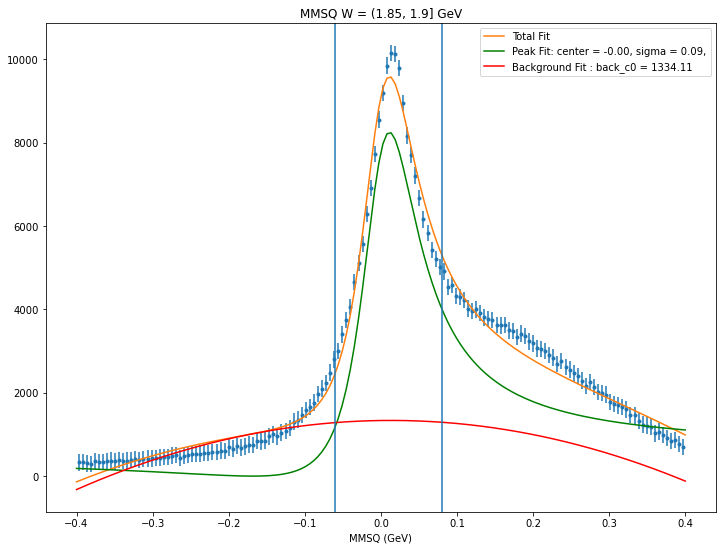

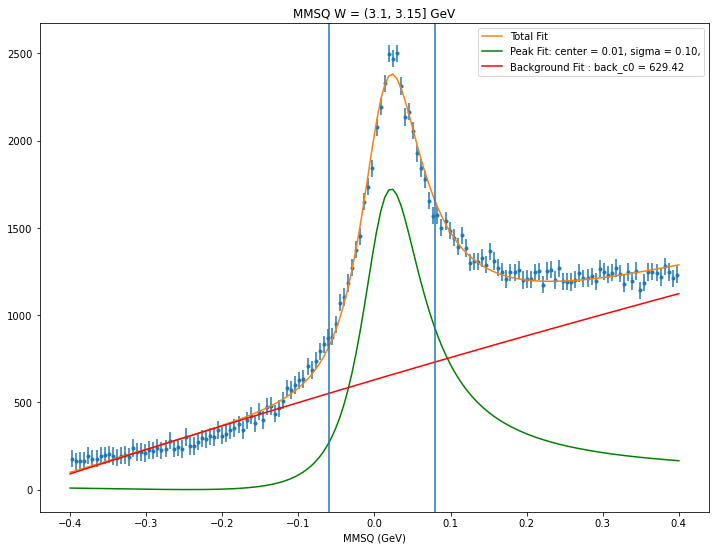

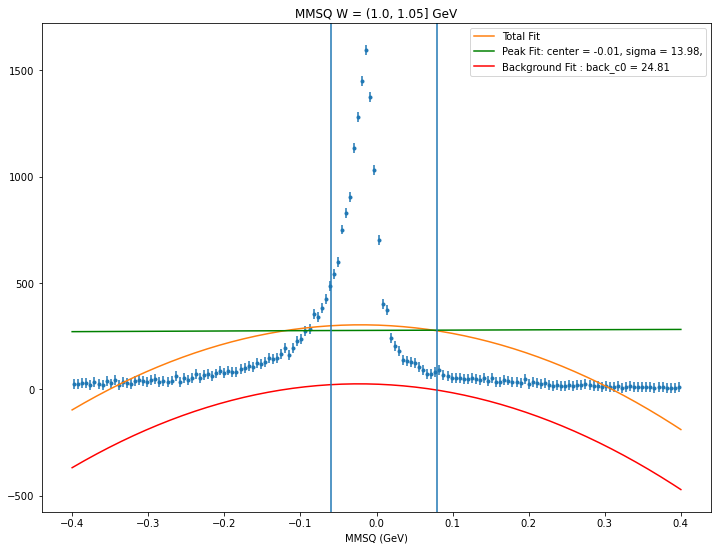

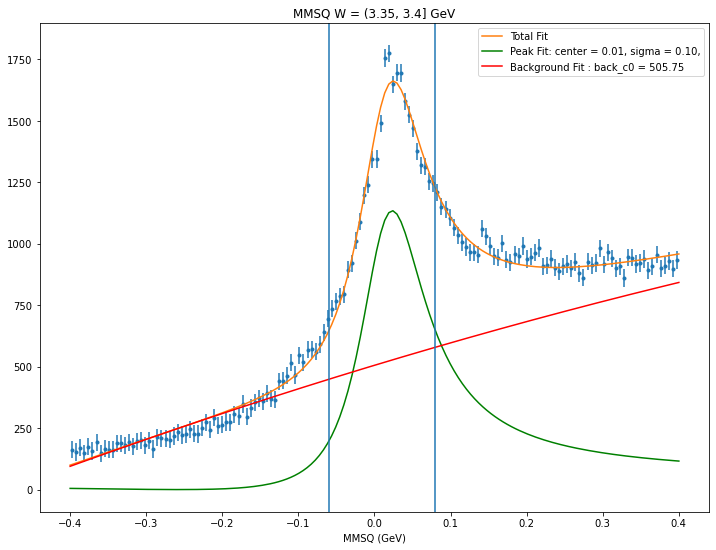

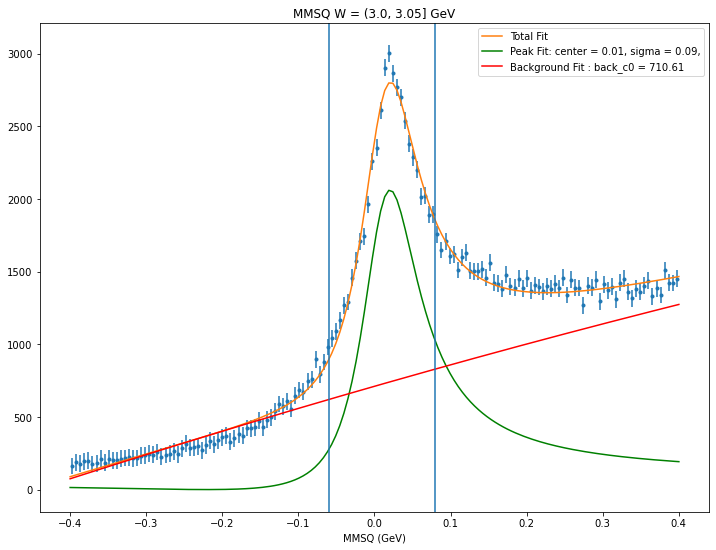

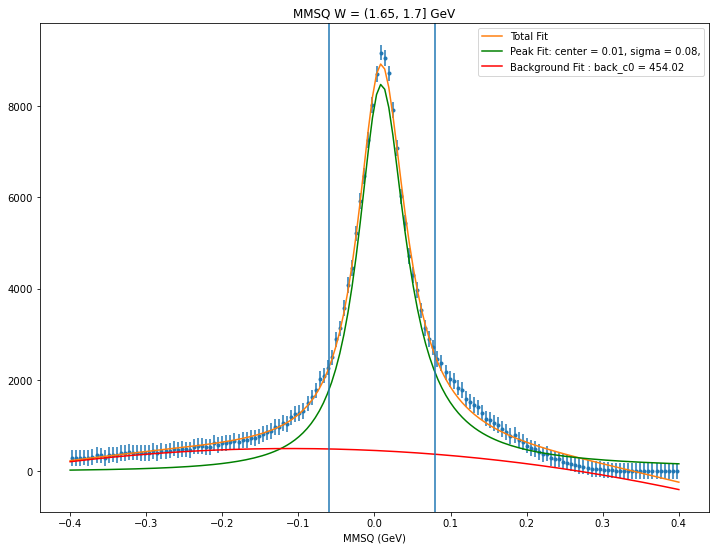

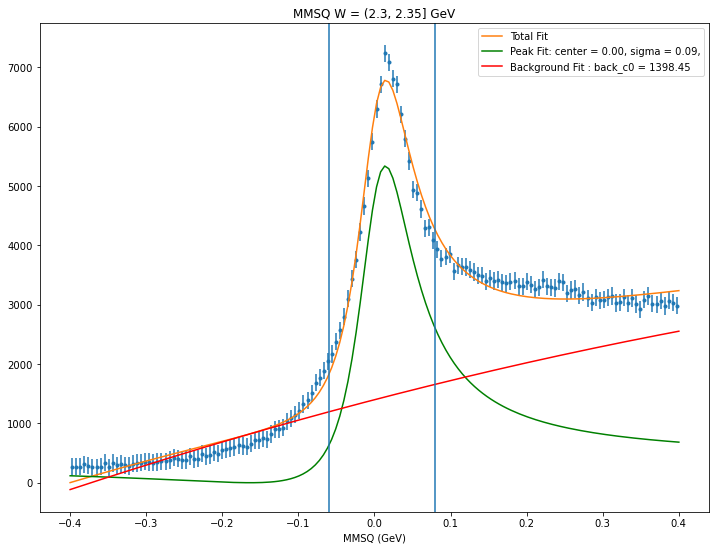

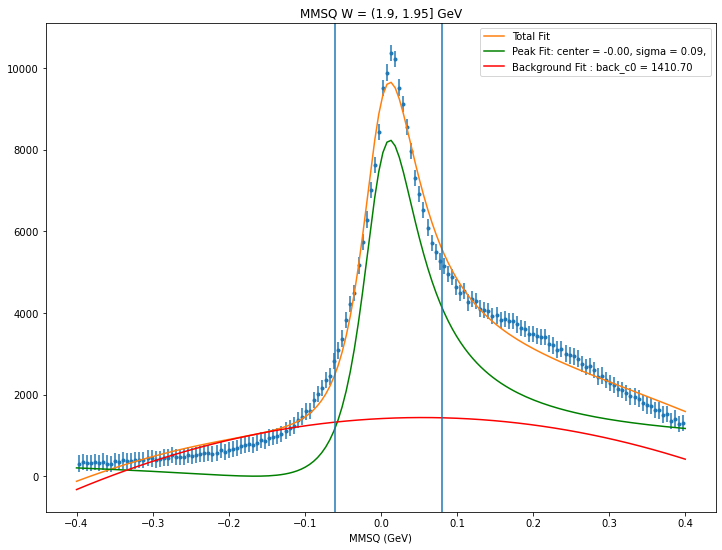

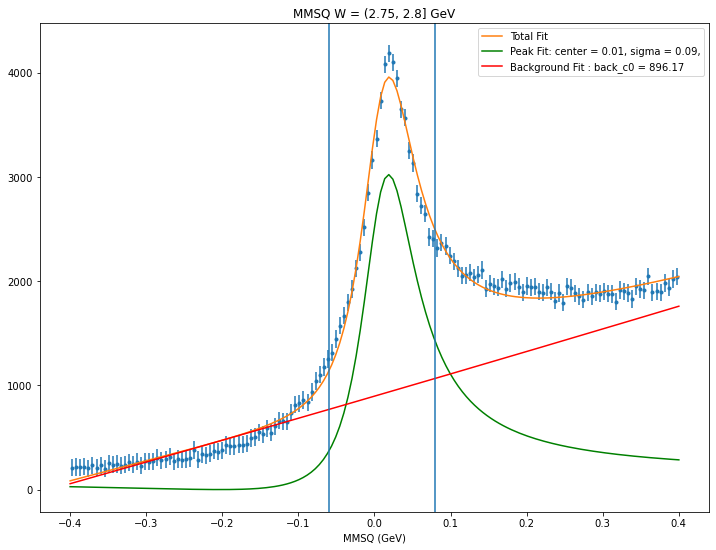

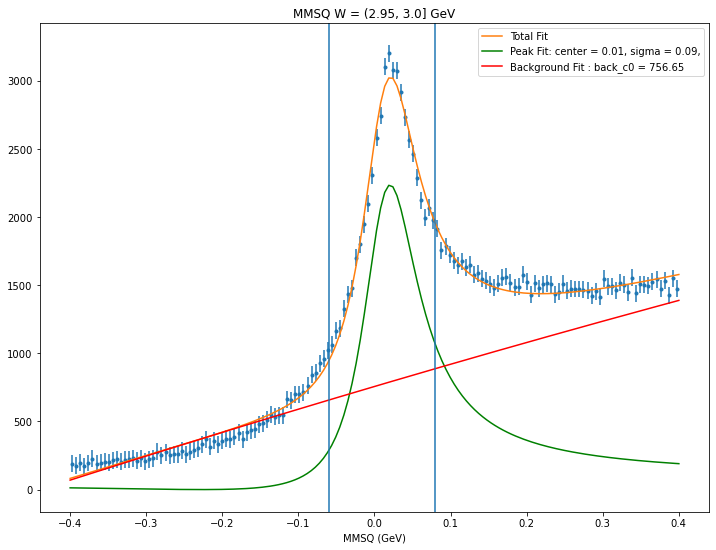

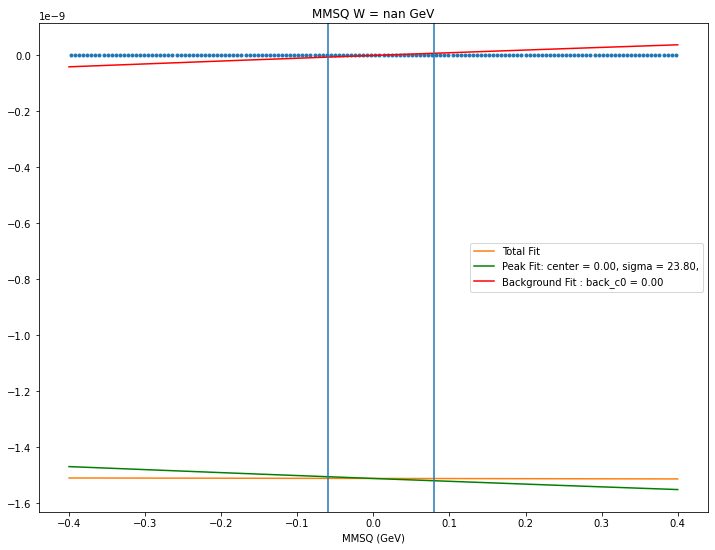

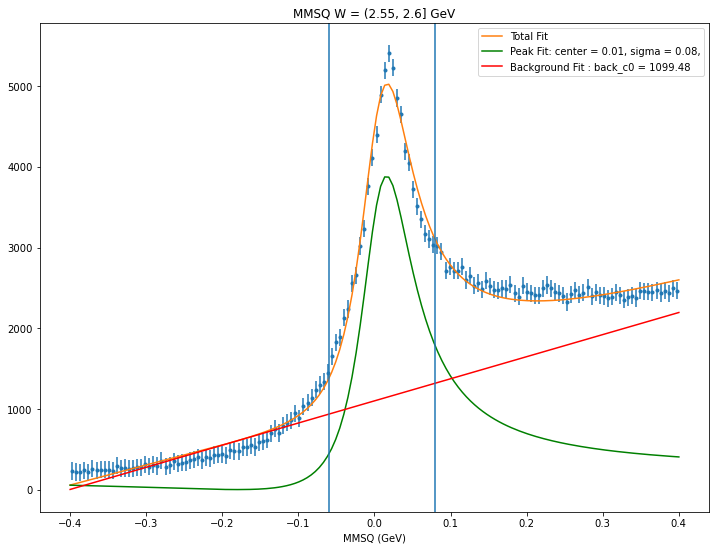

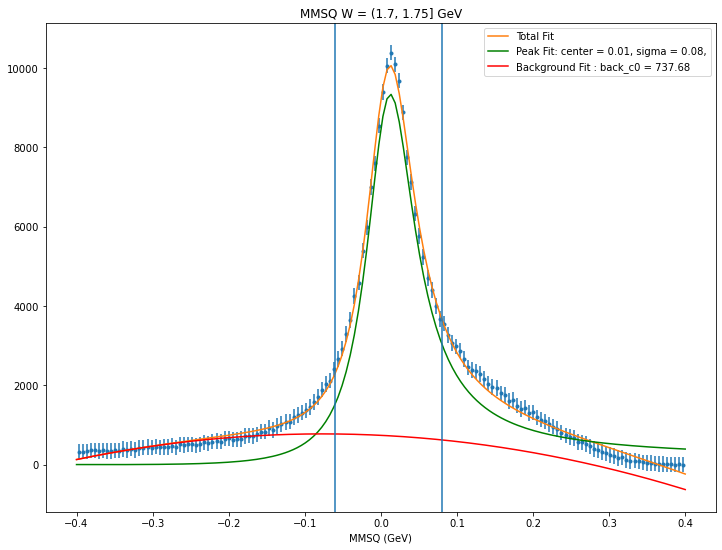

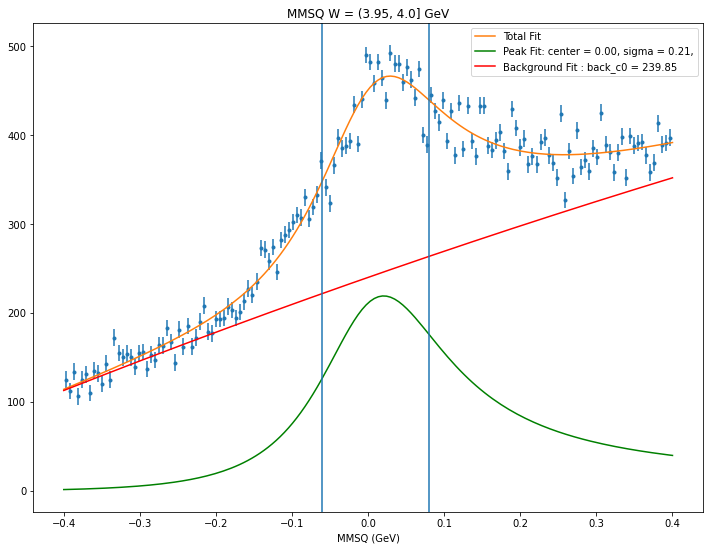

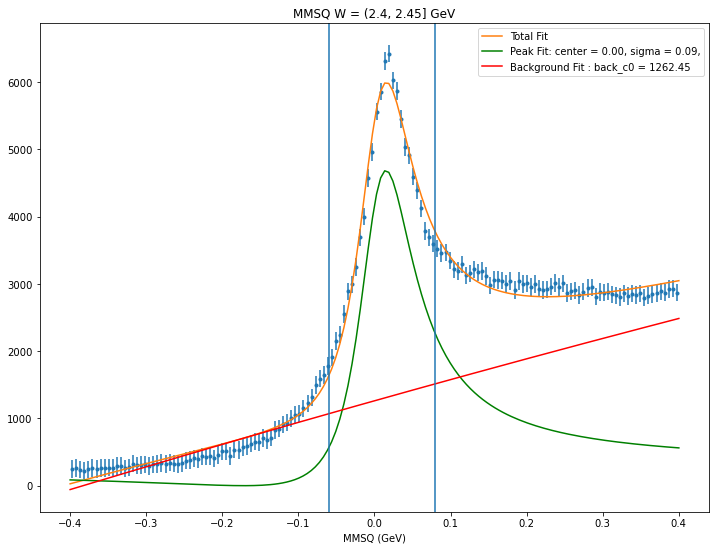

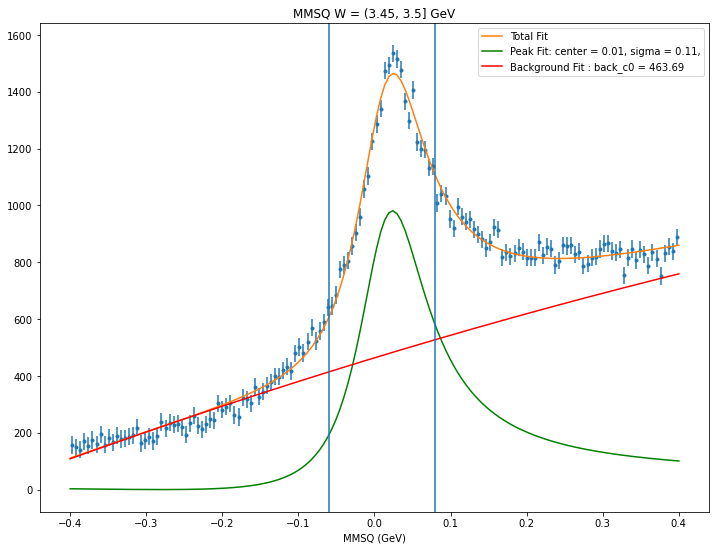

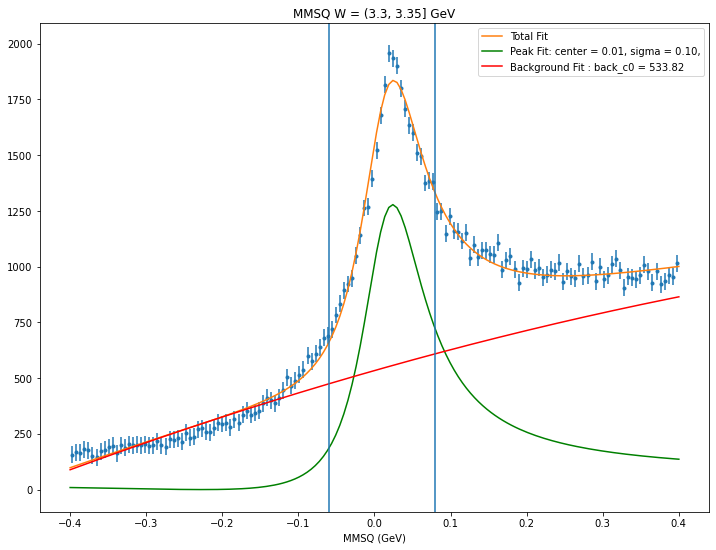

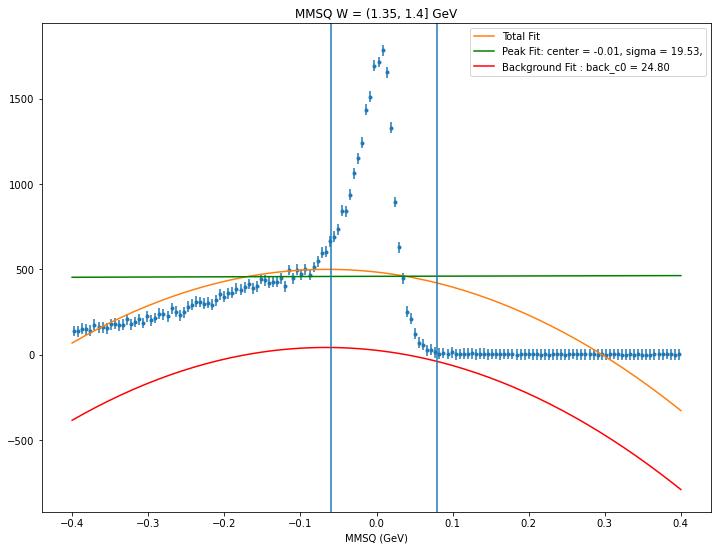

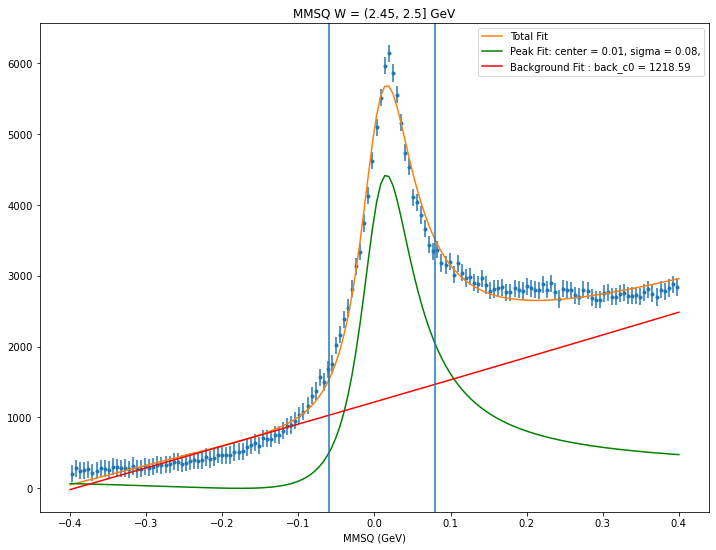

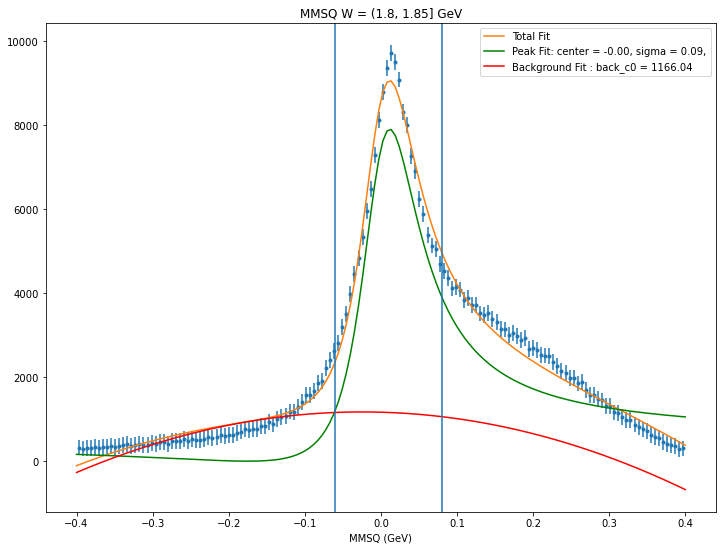

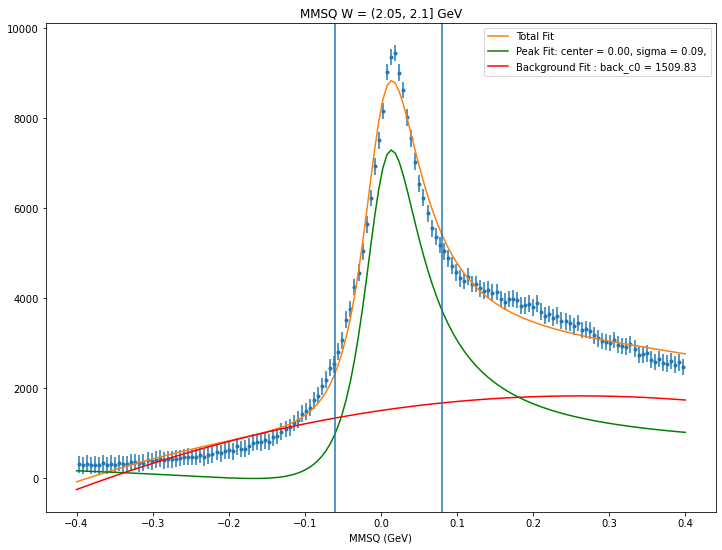

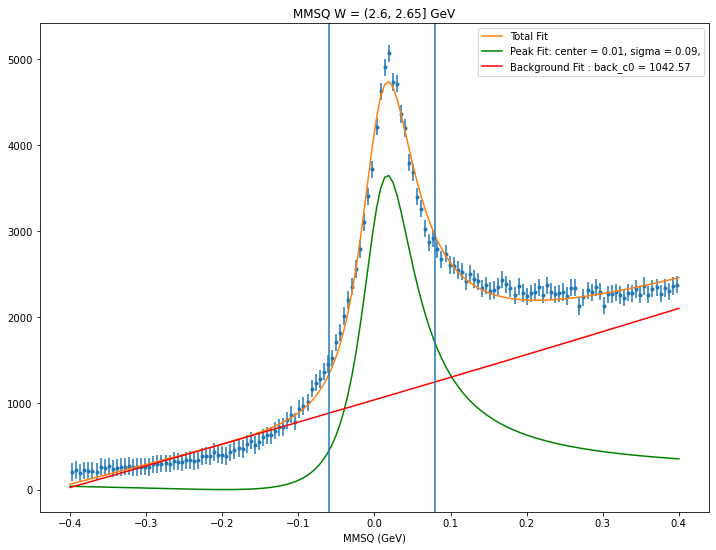

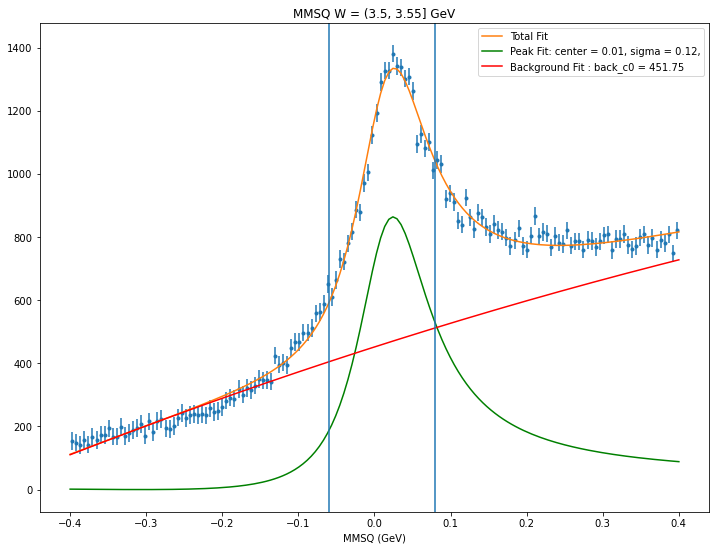

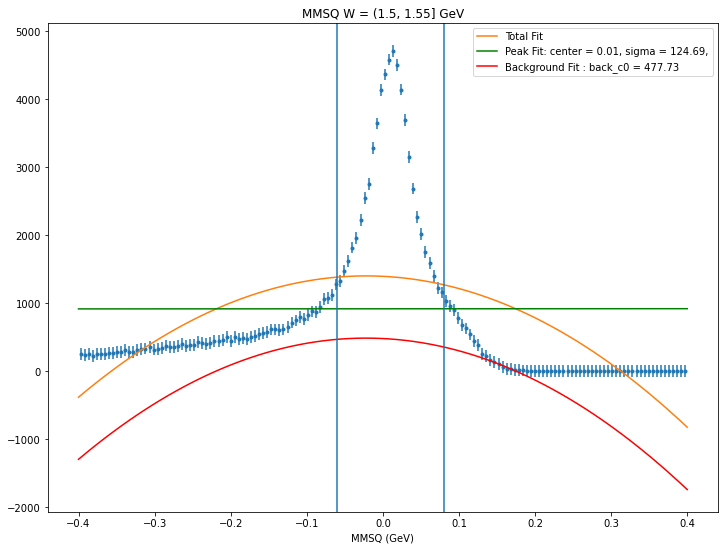

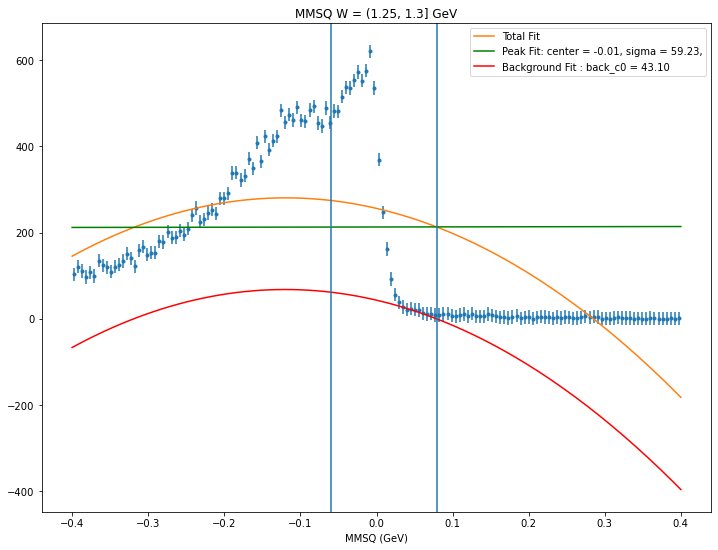

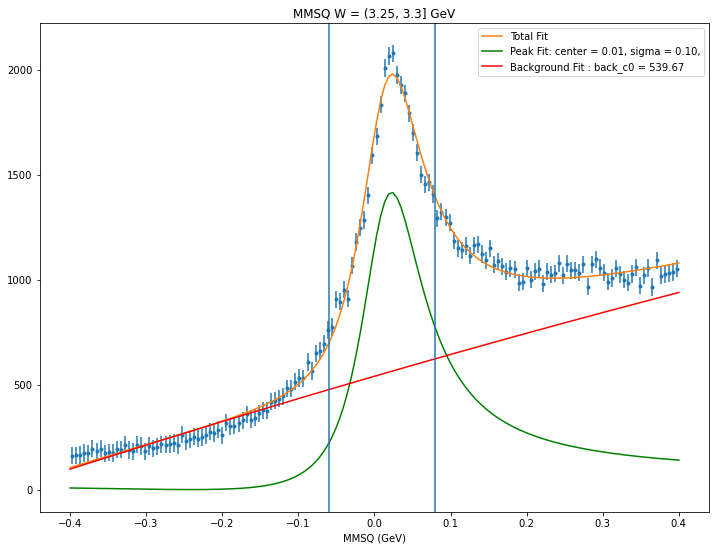

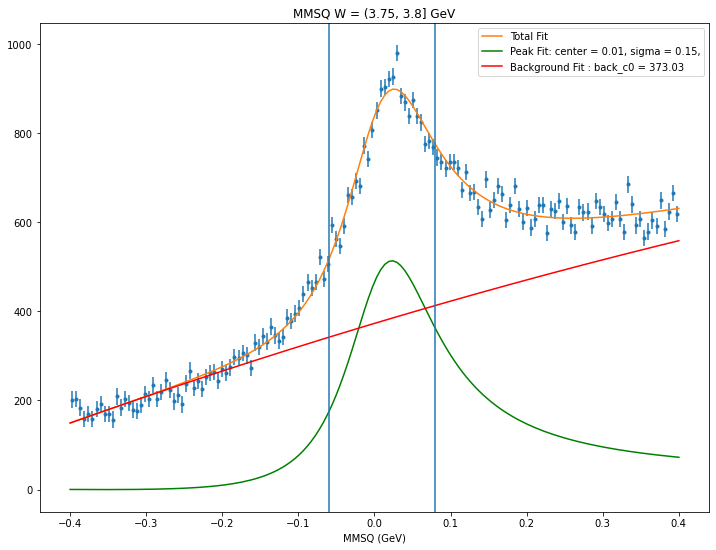

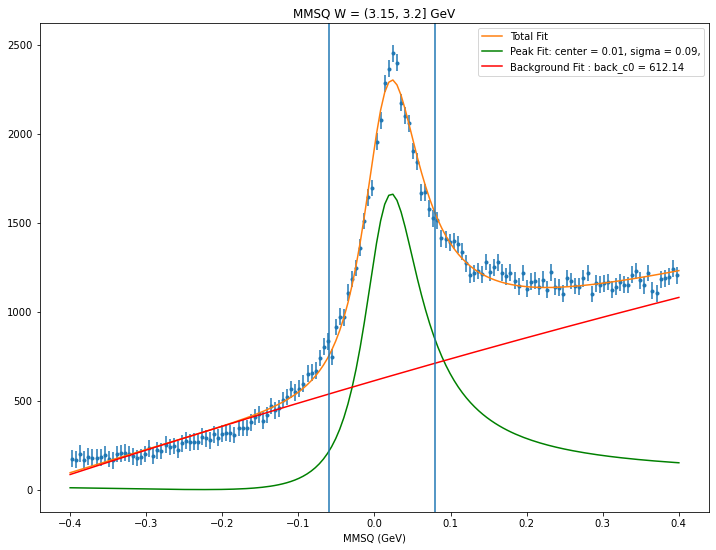

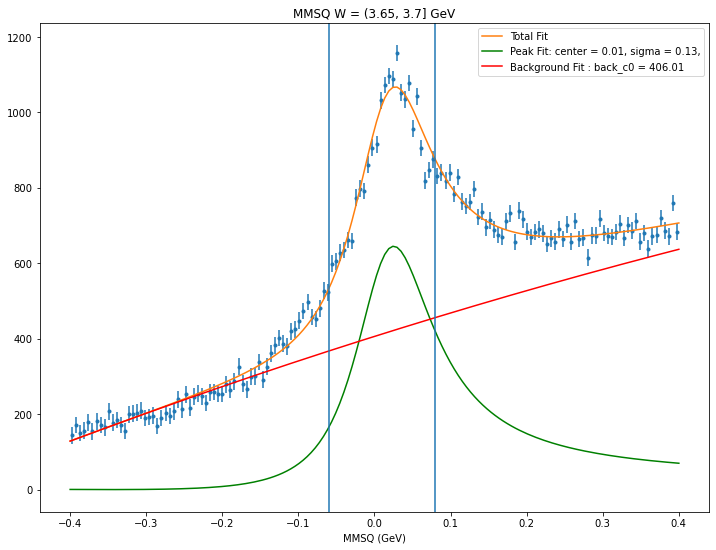

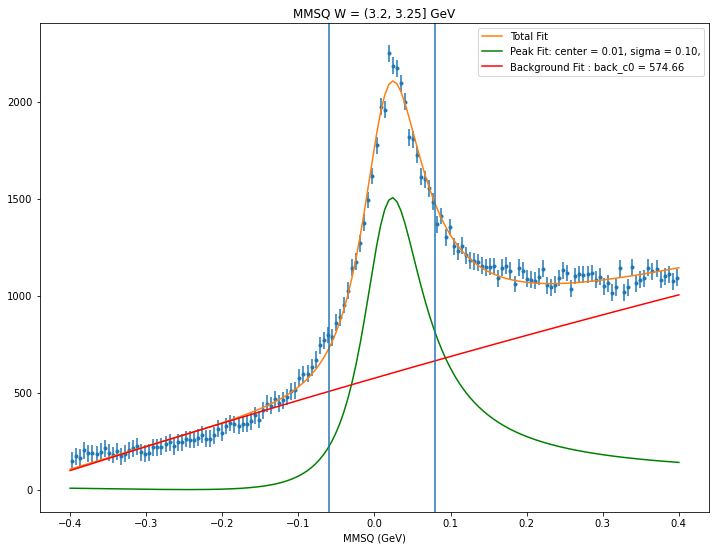

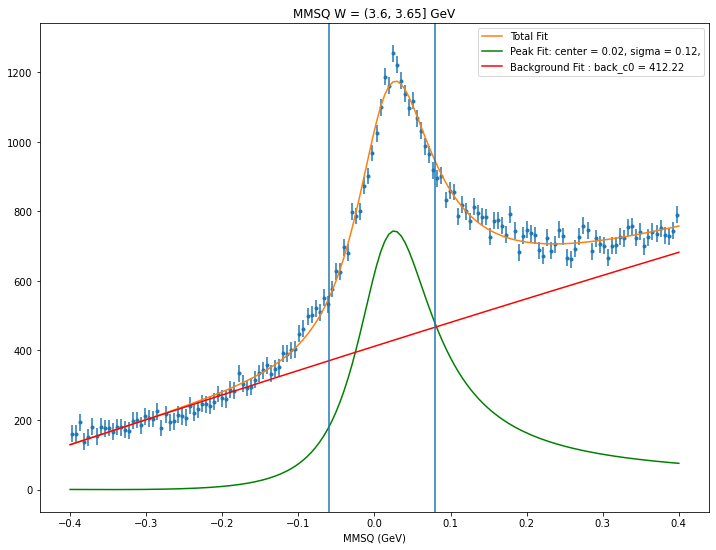

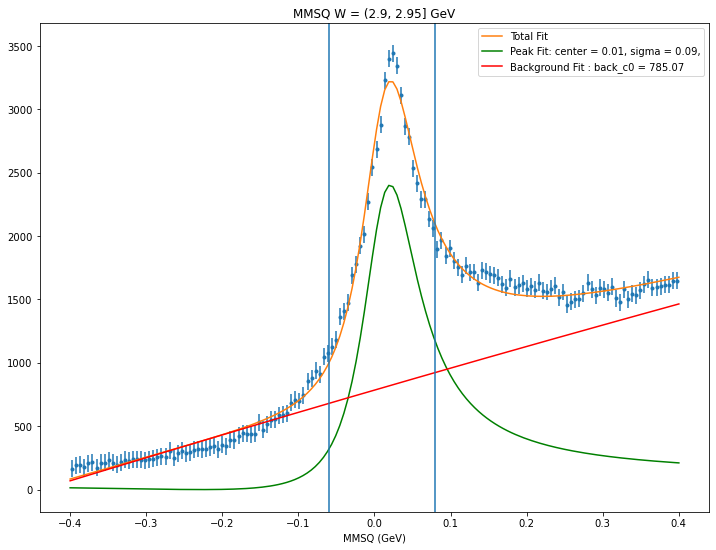

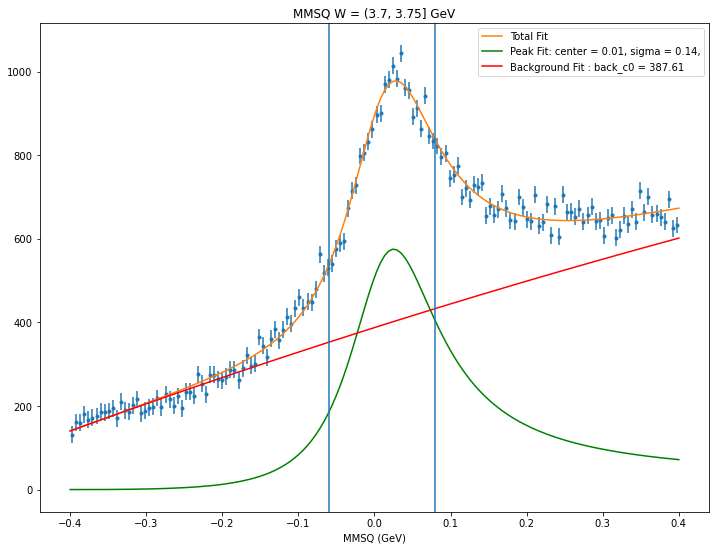

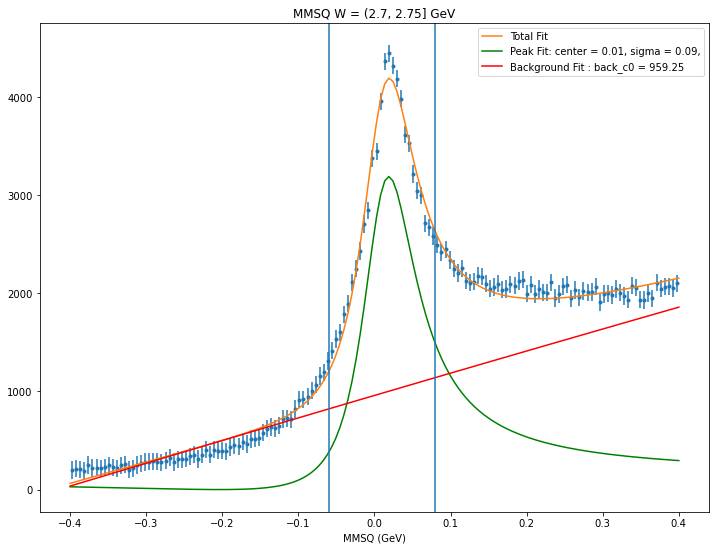

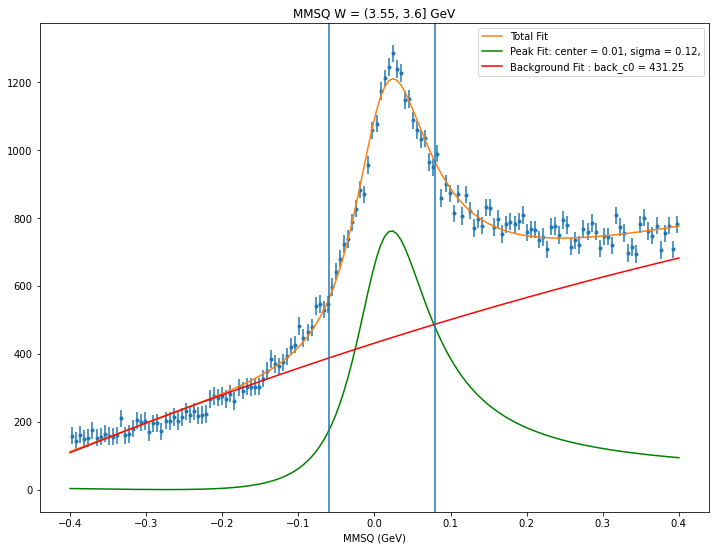

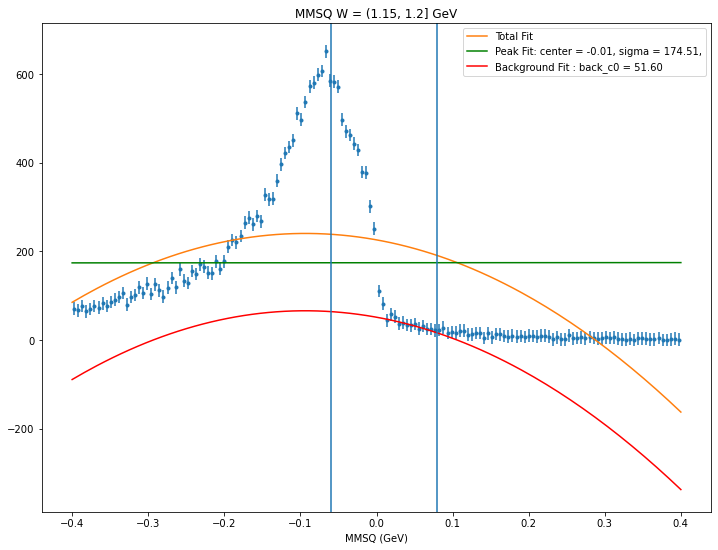

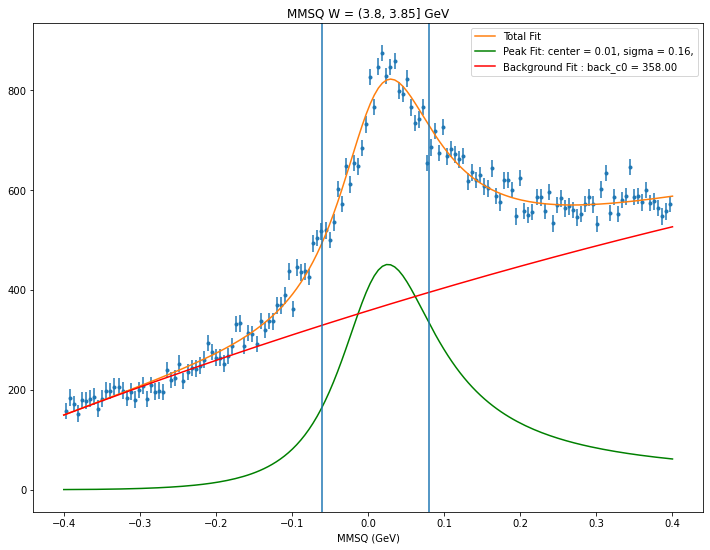

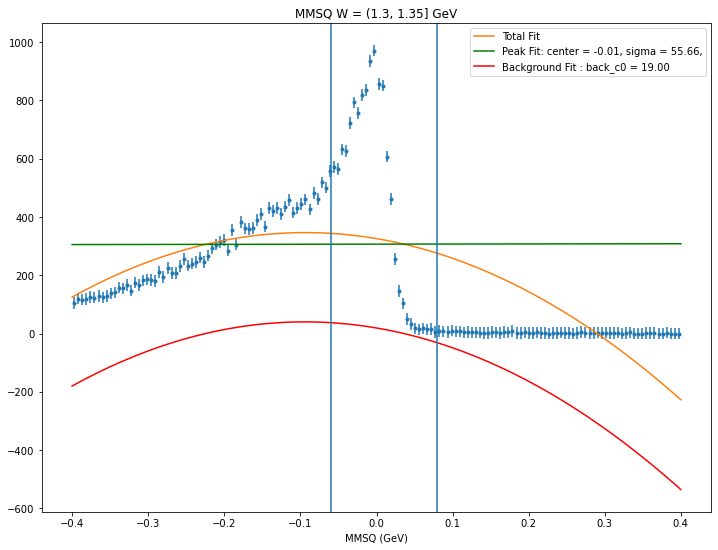

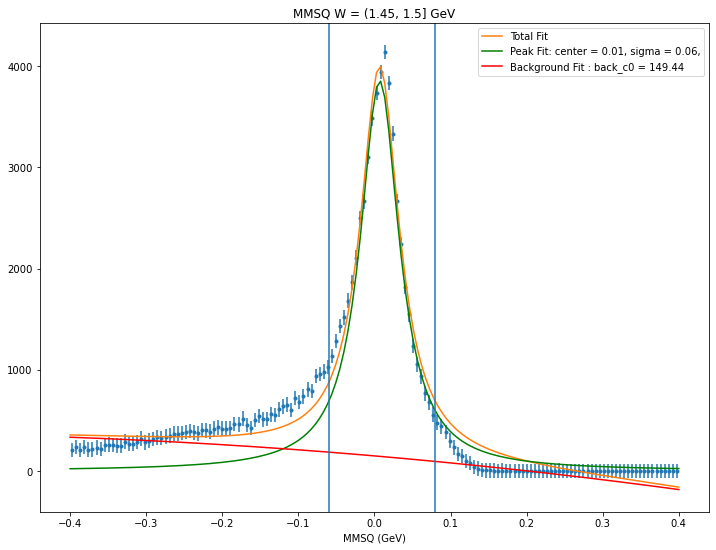

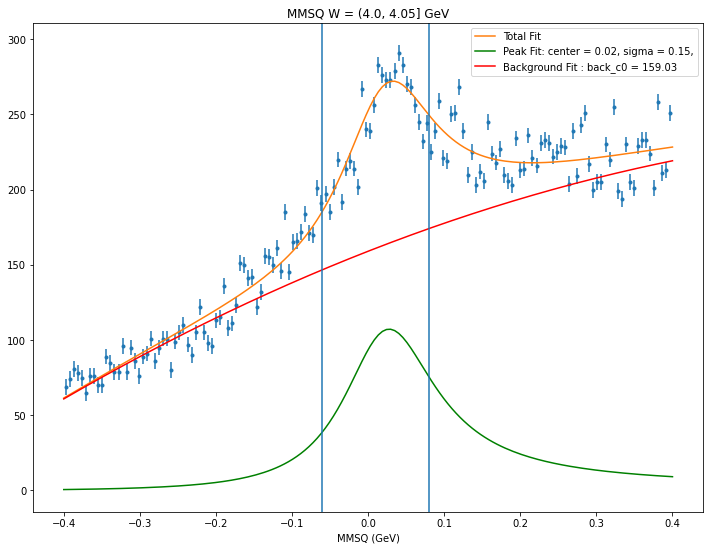

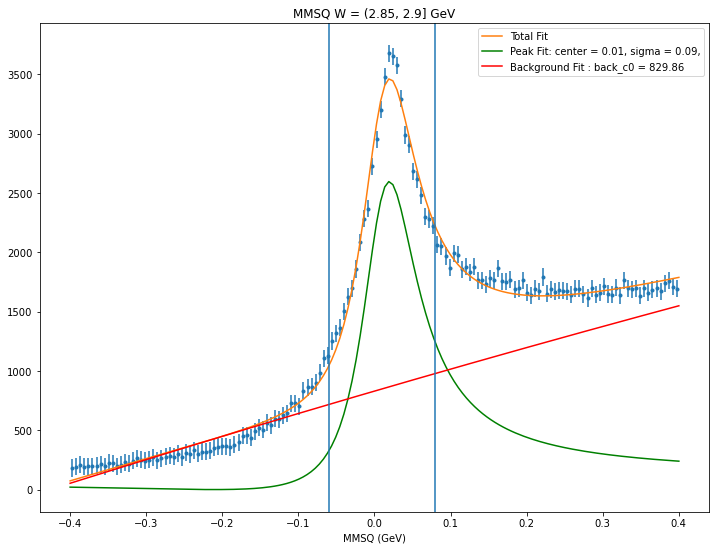

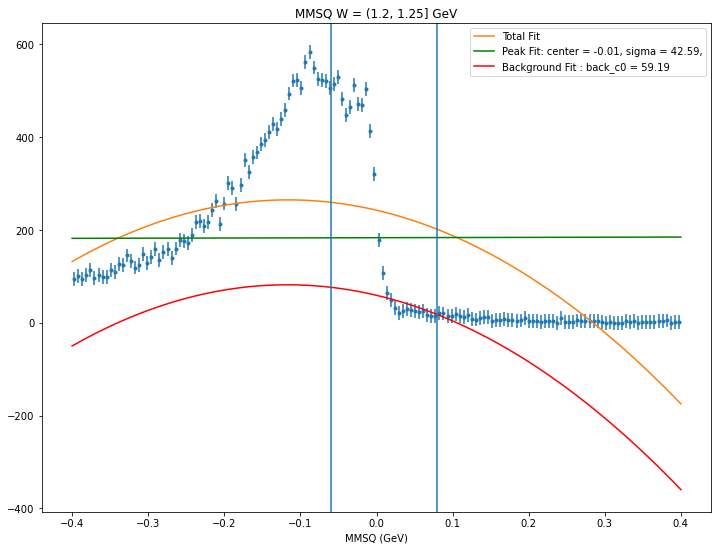

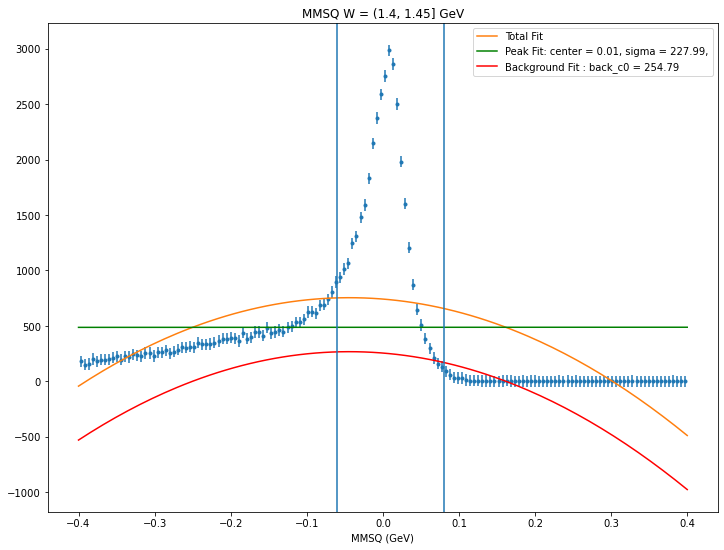

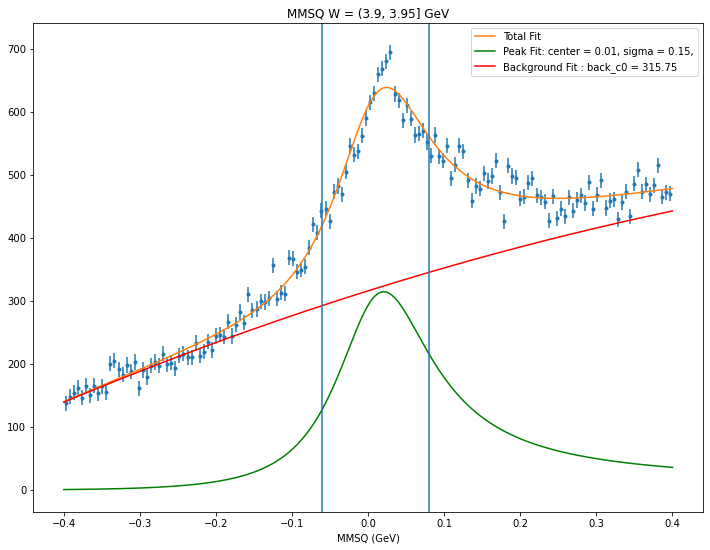

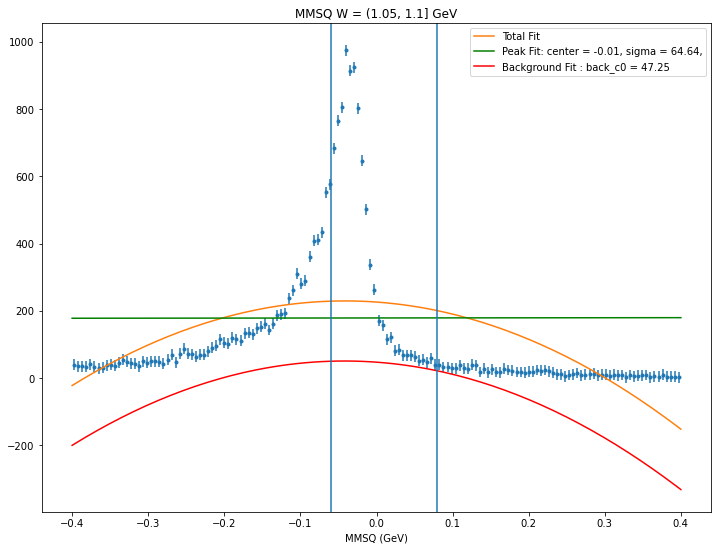

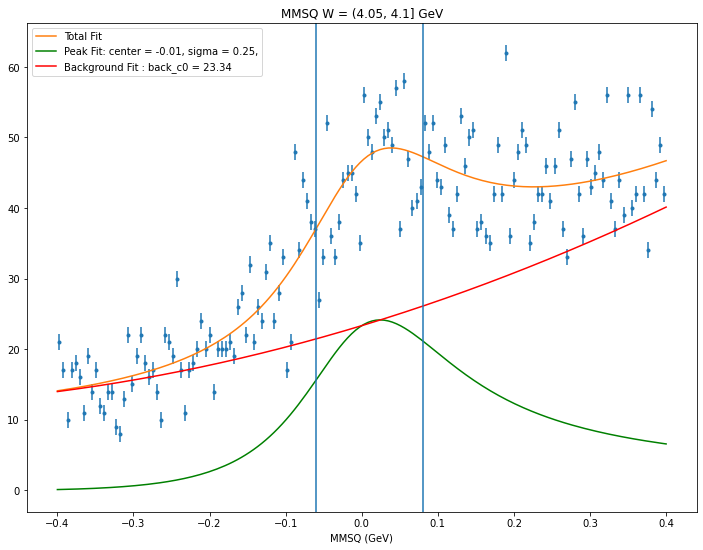

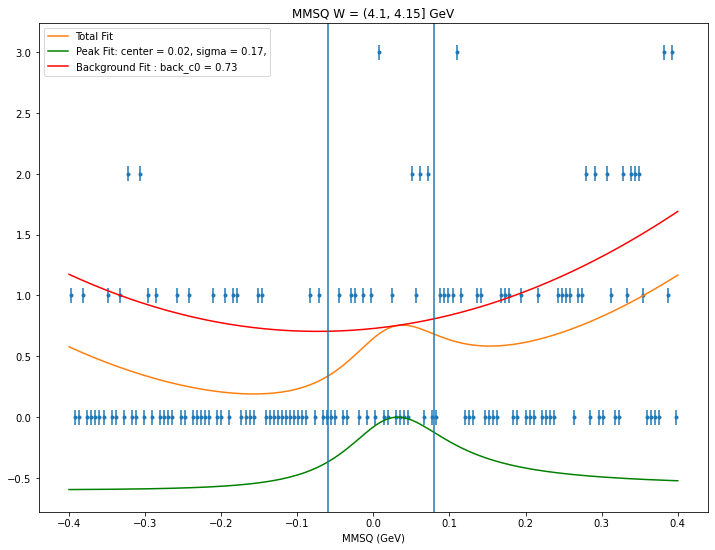

In [17]:
w_cuts = mm_cut(rec)

In [28]:
# Create function to
import sys
from scipy import integrate
def mm_cut(df):
    NSIGMA = 4
    cut_data = {}
    # Makes a list from 0 to 10 spaced by 1
    mom_bin_ranges = [0, 1, 2, 3, 10]
#     np.arange(0,10., 5.0)
    # Cuts the mom data into the ranges from above
    rec['mom_bin'] = pd.cut(rec.pim_mom_mPim, mom_bin_ranges)
    unique_mom = rec.mom_bin.unique()
    
    # Makes a list from 0 to 180 spaced by 18
#     theta_bin_ranges = np.arange(0,180.1, 90.0)
    theta_bin_ranges = [0,18,36, 180]
    # Cuts the theta data into the ranges from above
    rec['theta_bin'] = pd.cut(rec.pim_theta_mPim, theta_bin_ranges)
    unique_theta = rec.theta_bin.unique()
    
    # Makes a list from 0 to 360 spaced by 120
    phi_bin_ranges = [0, 180, 360]
#     np.arange(0,361, 180.0)
    # Cuts the phi data into the ranges from above
    rec['phi_bin'] = pd.cut(rec.pim_phi_mPim, phi_bin_ranges)
    unique_phi = rec.phi_bin.unique()
    
    
    for mom in unique_mom:
#         data = rec[rec.mom_bin == mom]
        for theta in unique_theta:
#             data = rec[rec.theta_bin == theta]
            for phi in unique_phi:
#                 data = rec[rec.phi_bin == phi] 
                data = rec[(rec.mom_bin == mom) & (rec.theta_bin == theta) & (rec.phi_bin == phi)] 
                
#       The bin edges are saved as left and right
#         print(phi.left, phi.right)
#                 s = f'{mom.left}_{theta.left}_{phi.left}'
                s = f'MMSQ mom={mom} GeV  \u03B8 = {theta}  $\phi$ = {phi}'
#                 s = "MMSQ-Mom = ("+str(mom.left)+"-"+str(mom.right)+') GeV_'+'\u03B8 = (' + str(theta.left)+"-"+str(theta.right)+")\u00B0_"+"\u03C6 = ("+str(phi.left)+'-'+str(phi.right)+')\u00B0'
                # Make a figure to plot on
                plt.figure(figsize=(12,9))
                # Histogram the data and 
                y,x = np.histogram(data.mm2_mPim.to_numpy(), 
                                 bins=300, range=(-0.4,0.4), density=False)
        
                # calculate bin centers
                x=(x[1:]+x[:-1])/2

                # Plot points on
                plt.errorbar(x,y,yerr=stats.sem(y), fmt='.', zorder=1)

                # Make a model with a peak
                peak = BreitWignerModel(prefix="peak_")
                pars = peak.make_params()
                # Set some parameters
                pars['peak_center'].set(value=0, min=-0.20, max=0.2)
                #pars['peak_sigma'].set(value=0.1, min=0.0, max=0.5)
                #pars['peak_amplitude'].set(value=0.5)
        
                # Set the background
                background =  PolynomialModel(2, prefix="back_")
                pars.update(background.guess(y, x=x))
                pars['back_c0'].set(value=0.1,min=0.)
        
                # Make full model to fit
                model = peak + background
        
                # Fit our full model
                out = model.fit(y, pars, x=x)
        
                # Make a more fine set of x's to plot with
                xs= np.linspace(-0.4, 0.4, 300)
        
                # Plot our output model withe the new parameter and finer x's
                plt.plot(xs, out.eval(params=out.params, x=xs), label='Total Fit')

                # Get the components of the fit for our finer x's
                comps = out.eval_components(x=xs)
                # Plot just the peak component
                plt.plot(xs, comps['peak_'], 
                    'g-', label=f"Peak Fit: center = {out.params['peak_center'].value:0.2f}, sigma = {out.params['peak_sigma'].value:0.2f},")

                plt.plot(xs, comps['back_'], 'r-',
                    label=f"Background Fit : back_c0 = {out.params['back_c0'].value:0.2f}")
                # Plot center +- sigma where we will cut later
                #plt.axvline(out.params['peak_center']-NSIGMA*out.params['peak_sigma'])
                #plt.axvline(out.params['peak_center']+NSIGMA*out.params['peak_sigma'])
        
                # Put on labels and show the plot
                plt.title(s)
                xs=np.linspace(-0.06, 0.08, num = 53) # , retstep = True
                comps1 = out.eval_components(x=xs)
                total = integrate.simps(out.eval(x=xs))
                peak_out = integrate.simps(comps1['peak_'])
                background_out = integrate.simps(comps1['back_'])
    
#                 f = background # lambda x:exp(-x**2)
#                 TotalInt = intg.quad(f, -0.1, 0.11)
#     help(model.fit)
                print('total = ', total)
                print('signal = ', peak_out)
                print('background = ', background_out)
                print('ratio = ', peak_out/background_out)
                plt.xlabel('MMSQ (GeV)')
#             plt.ylabel('Y')
                plt.legend()
                plt.show()
#                 print(mom)
#                 print(theta)
#                 print(phi)
            # Save cut data to our
                cut_data[mom,theta,phi]= (out.params['peak_center']-NSIGMA*out.params['peak_sigma'], 
                                out.params['peak_center']+NSIGMA*out.params['peak_sigma'])

            
        

    return cut_data

total =  223156.13973512157
signal =  115908.8106580628
background =  107247.32907705875
ratio =  1.0807617462881582


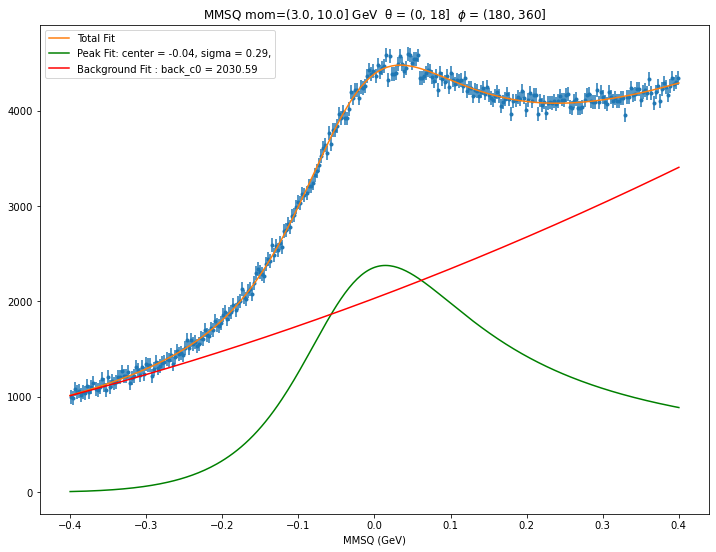

total =  217275.3520818475
signal =  113460.81661333935
background =  103814.53546850813
ratio =  1.0929184058985402


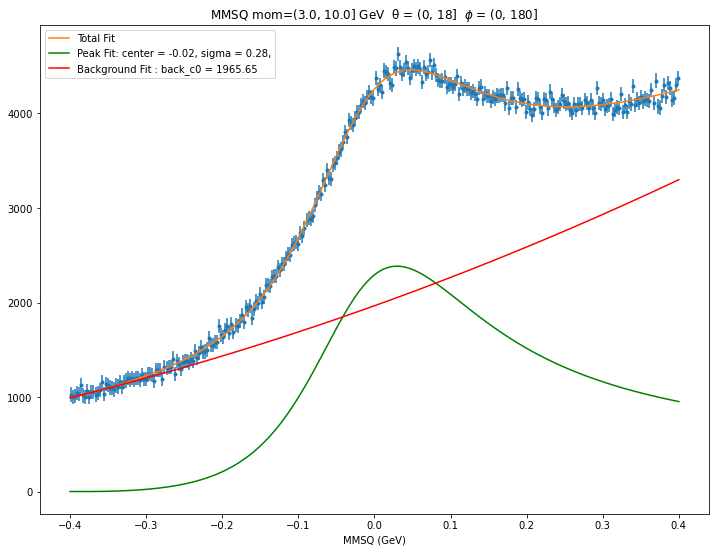

total =  23923.65377075624
signal =  14068.750998730075
background =  9854.902772026166
ratio =  1.4275890208338953


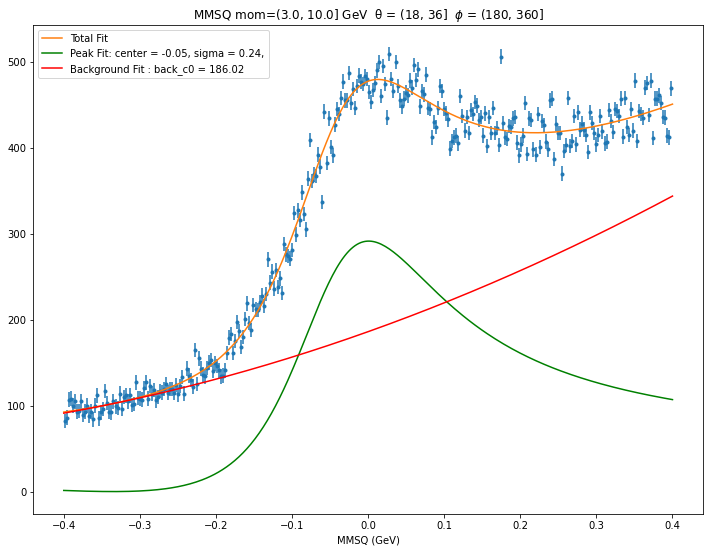

total =  23222.967306754334
signal =  13389.923443346195
background =  9833.043863408133
ratio =  1.3617272158394753


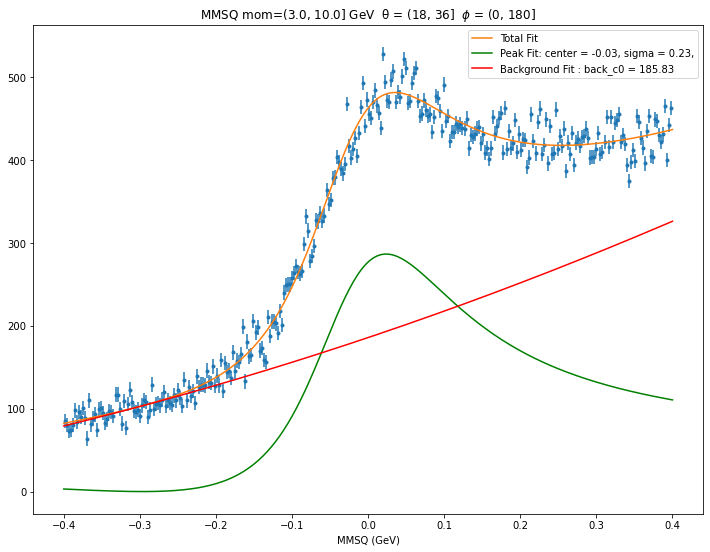

total =  185.18169500945535
signal =  31.738453215033037
background =  153.4432417944223
ratio =  0.2068416493543265


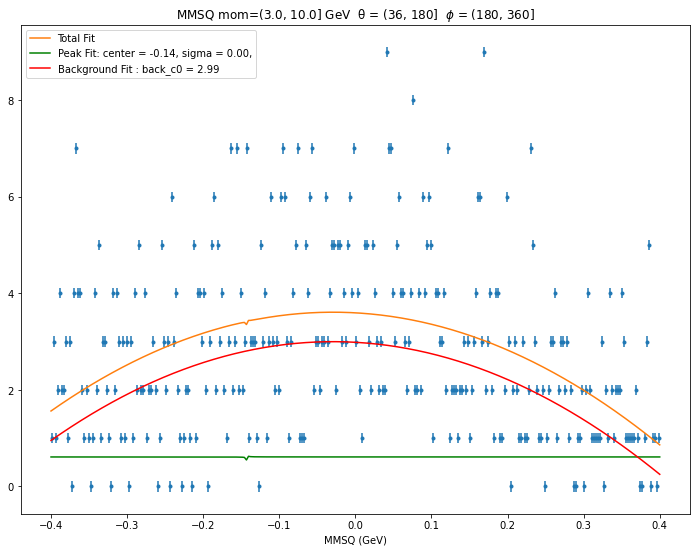

total =  408.5825068032428
signal =  132.37417603330113
background =  276.2083307699416
ratio =  0.47925482792029805


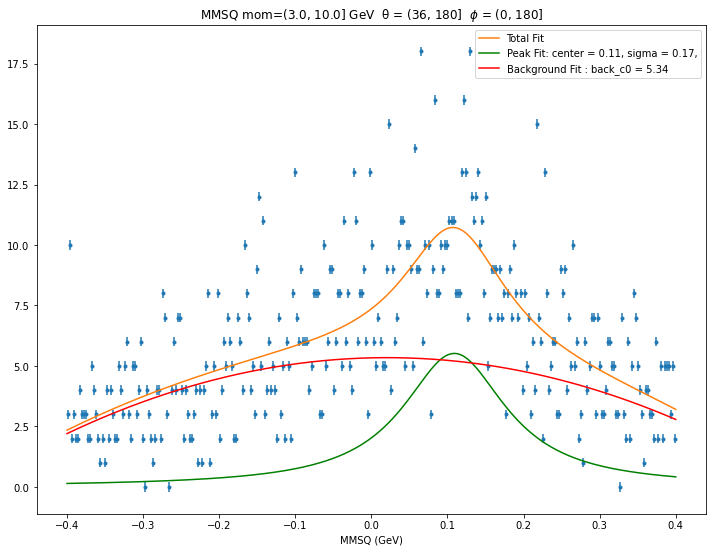

total =  157036.0181708272
signal =  133188.8675412386
background =  23847.1506295886
ratio =  5.585106145804402


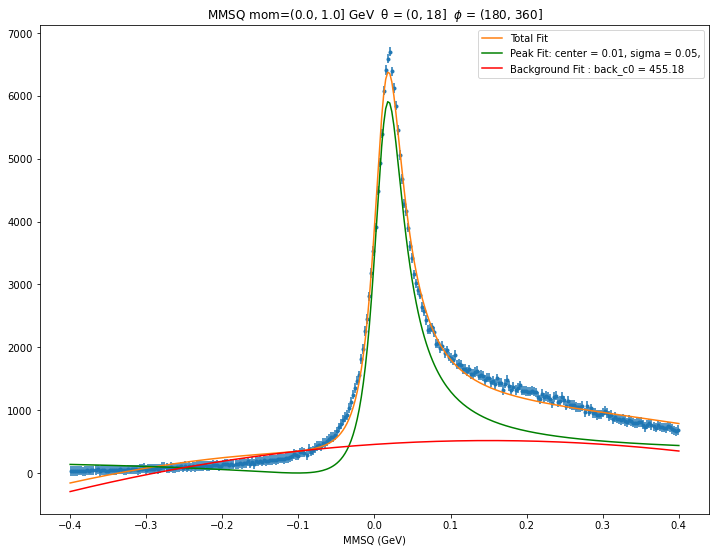

total =  89669.04418209869
signal =  15694.546483032835
background =  73974.49769906586
ratio =  0.21216158231826726


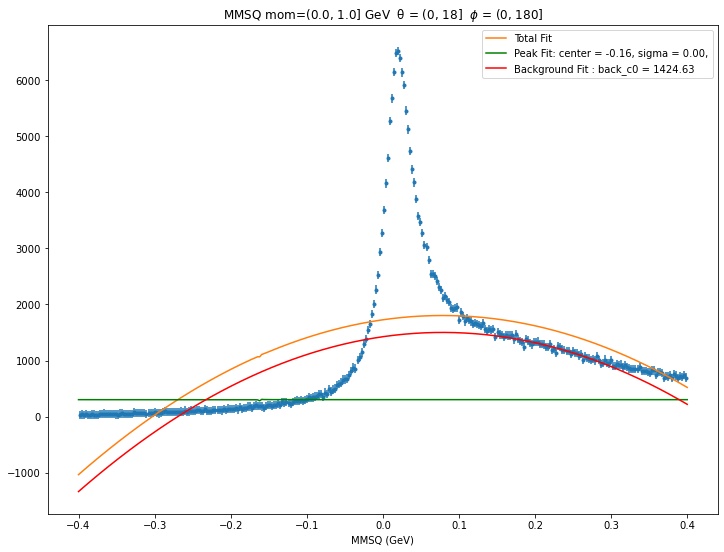

total =  301619.7644657902
signal =  250791.1138711023
background =  50828.65059468781
ratio =  4.934050204695242


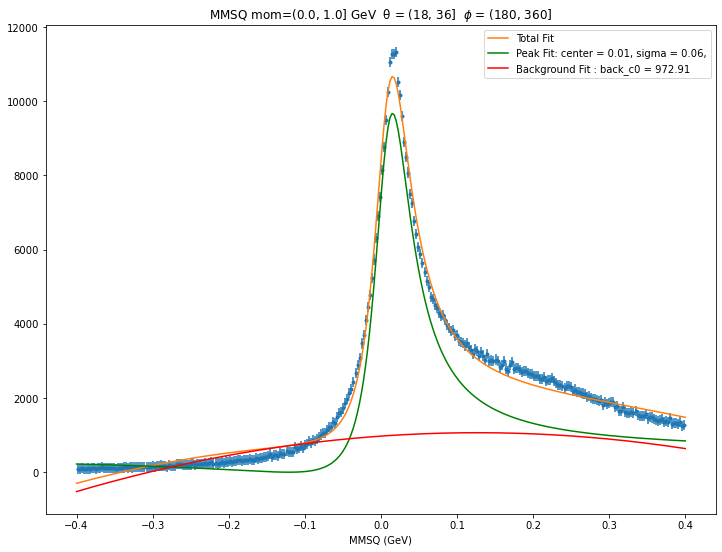

total =  294165.9414824982
signal =  241572.86029195128
background =  52593.081190546916
ratio =  4.593244107846102


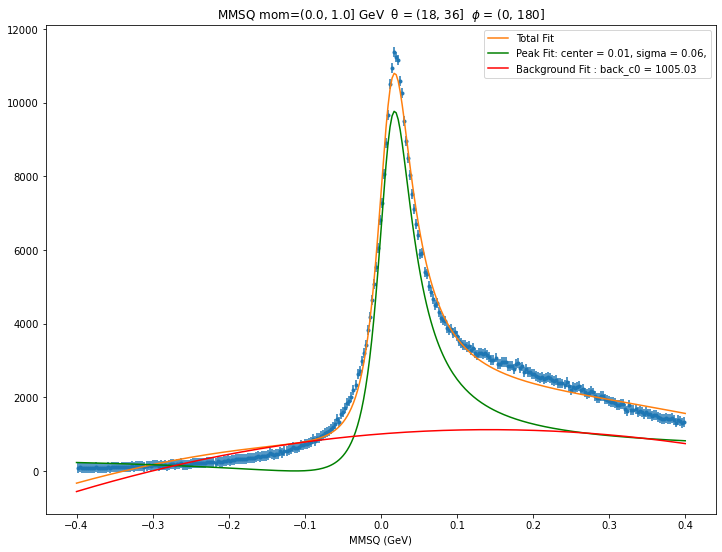

total =  718972.9086685603
signal =  651578.734450828
background =  67394.17421773226
ratio =  9.66817595161496


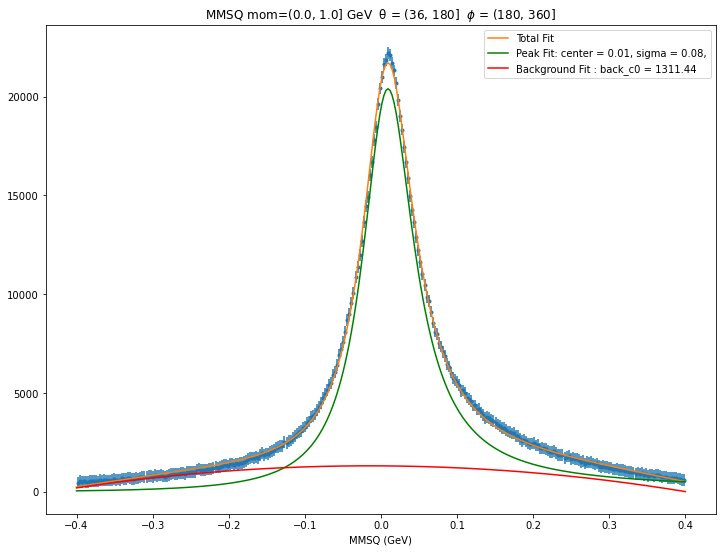

total =  711598.1071492188
signal =  637799.3278606582
background =  73798.77928856059
ratio =  8.642410267611599


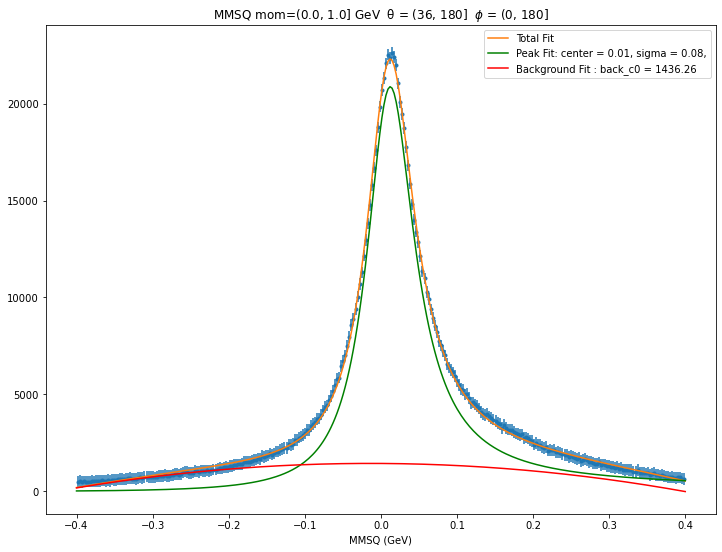

total =  131499.7977680018
signal =  88012.56662408683
background =  43487.23114391496
ratio =  2.023871474659342


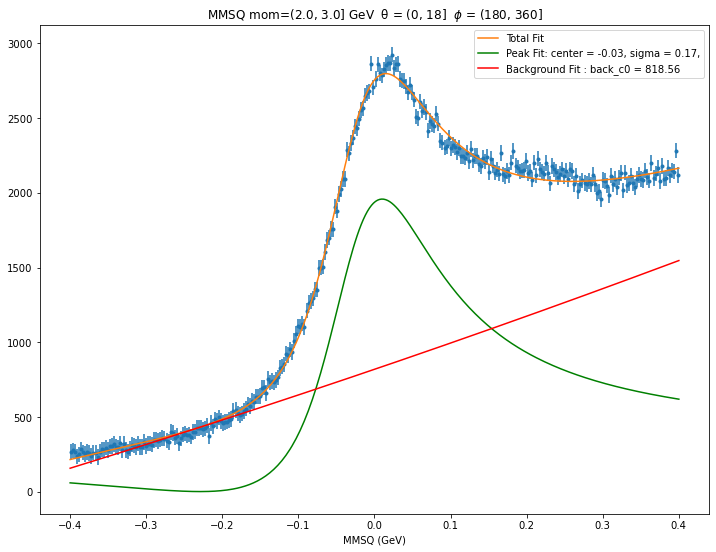

total =  129579.76103226254
signal =  85629.48594789146
background =  43950.27508437107
ratio =  1.9483265072518676


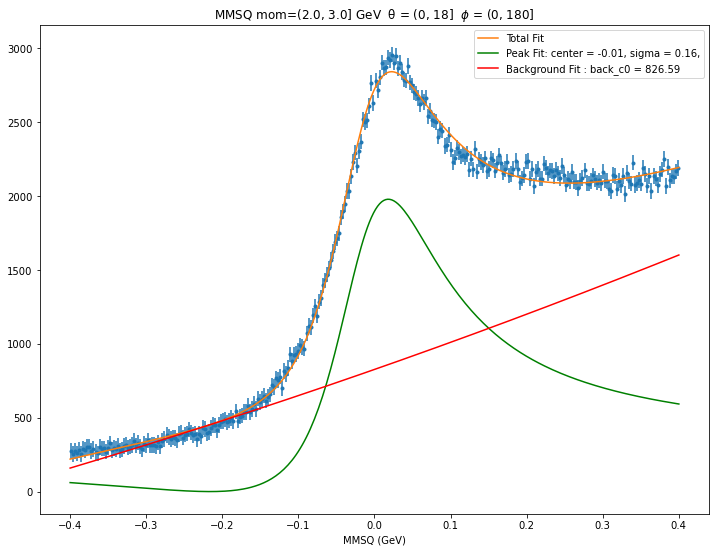

total =  88906.65897938599
signal =  55735.8417899183
background =  33170.81718946768
ratio =  1.6802673709110614


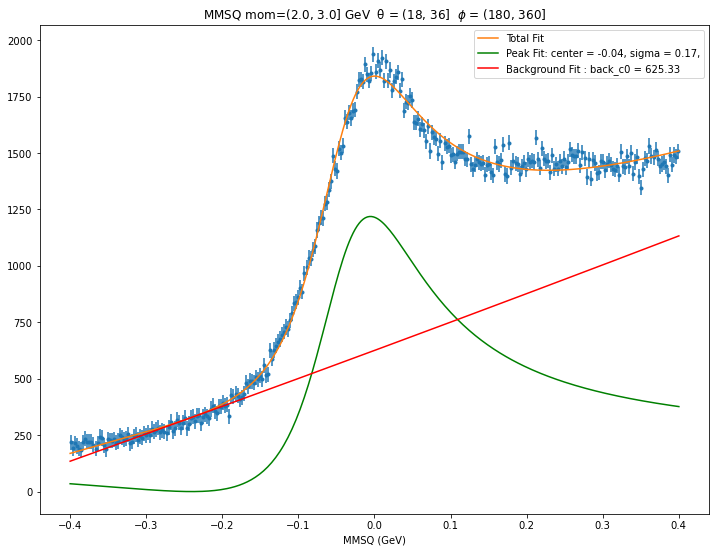

total =  87233.15611291166
signal =  55460.79008619782
background =  31772.366026713822
ratio =  1.7455668878914166


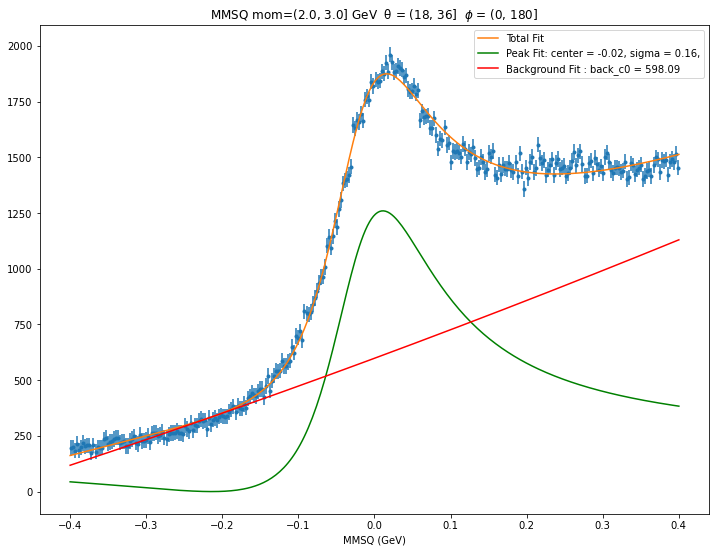

total =  2673.6448703542687
signal =  2051.866712322273
background =  621.7781580319956
ratio =  3.2999980552817805


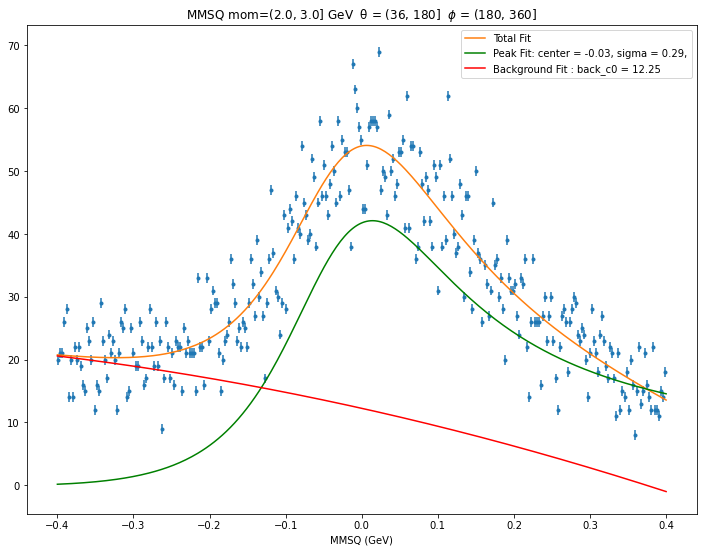

total =  3050.799774616244
signal =  2340.2306610968812
background =  710.5691135193625
ratio =  3.293459589744906


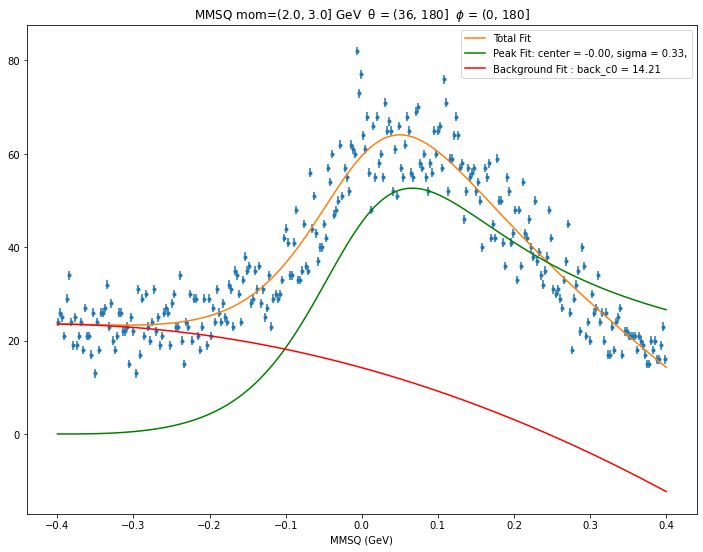

total =  210874.55470683426
signal =  158567.75941677595
background =  52306.79529005831
ratio =  3.031494446132014


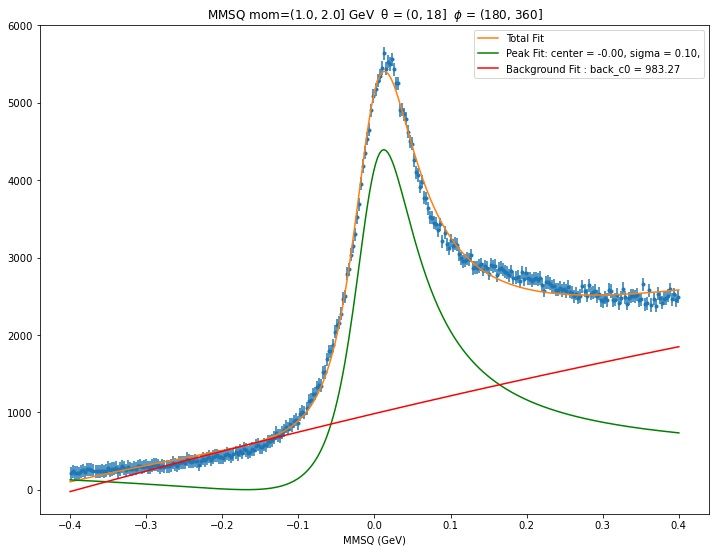

total =  206948.3147265516
signal =  152947.21273365628
background =  54001.10199289538
ratio =  2.8322979918776228


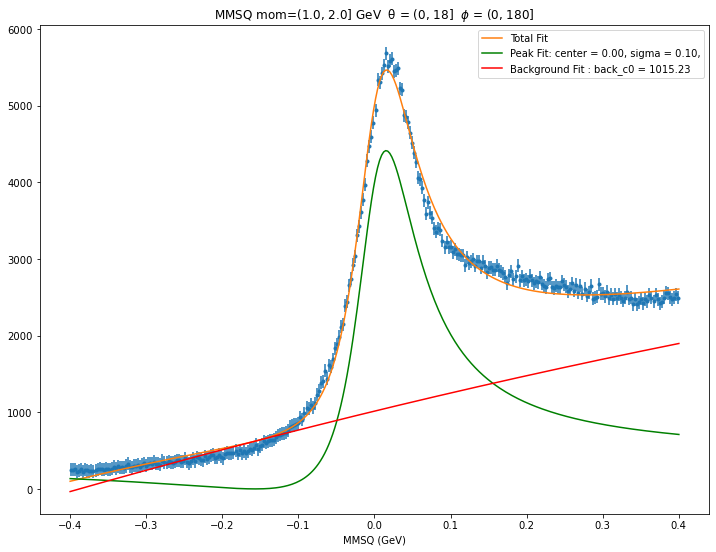

total =  186887.25869317167
signal =  56449.13442262185
background =  130438.12427054984
ratio =  0.4327656100415641


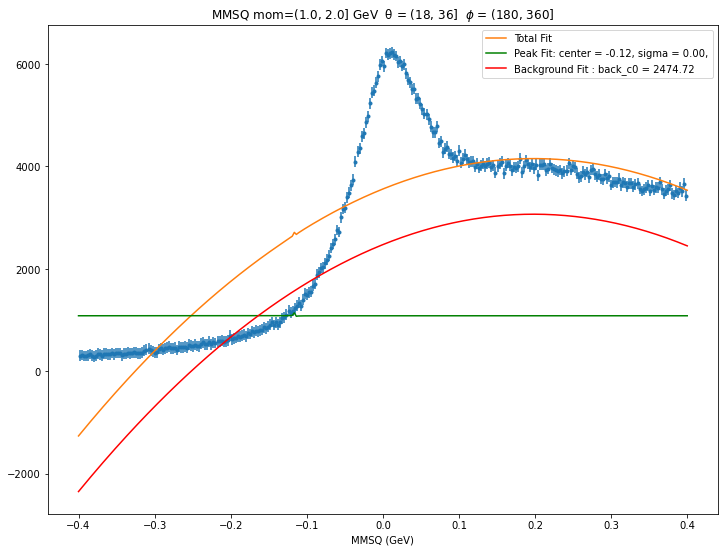

total =  257830.92513678316
signal =  180063.4225373857
background =  77767.50259939747
ratio =  2.3154070340273574


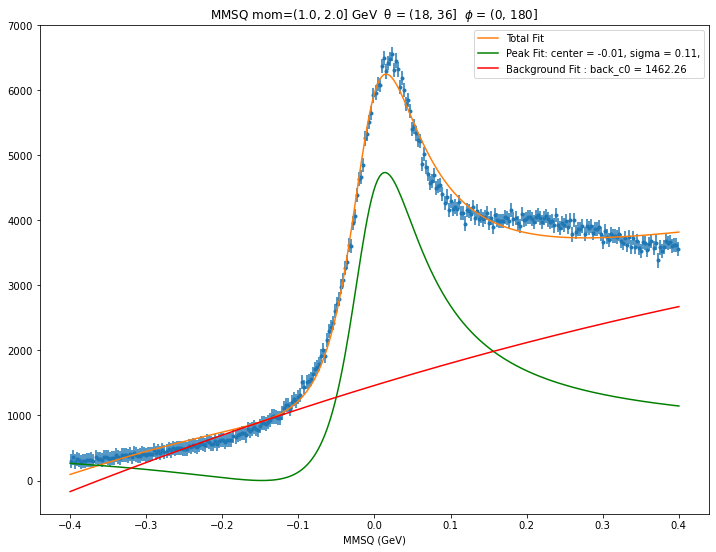

total =  111264.80736983426
signal =  87492.02683185524
background =  23772.78053797904
ratio =  3.680344698933273


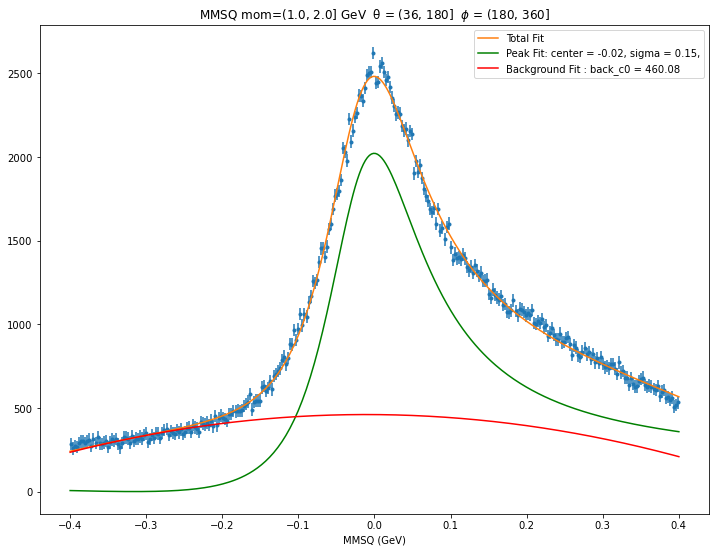

total =  113006.23616118425
signal =  87438.315039528
background =  25567.92112165626
ratio =  3.4198445240613227


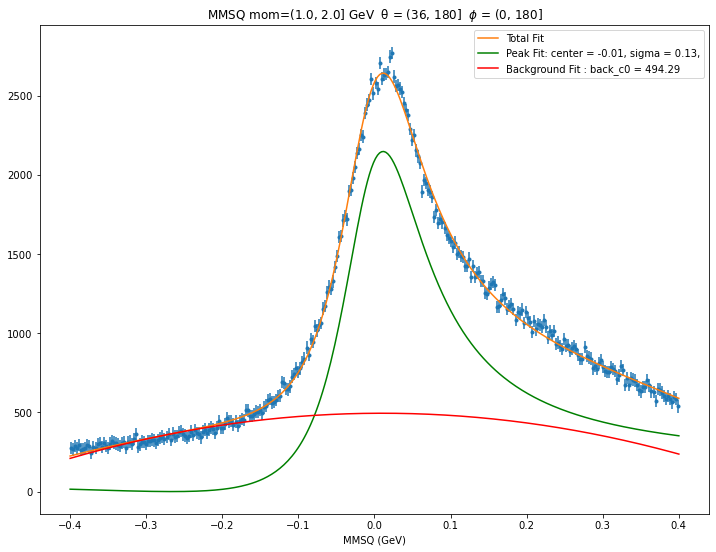

total =  -1.1410444286074486e-07
signal =  -1.1454663281853352e-07
background =  4.4218995778866604e-10
ratio =  -259.0439488751988


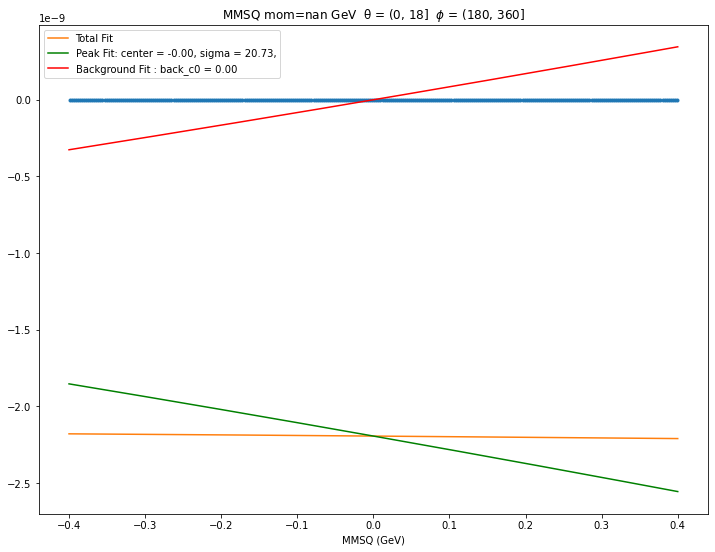

total =  -1.1410444286074486e-07
signal =  -1.1454663281853352e-07
background =  4.4218995778866604e-10
ratio =  -259.0439488751988


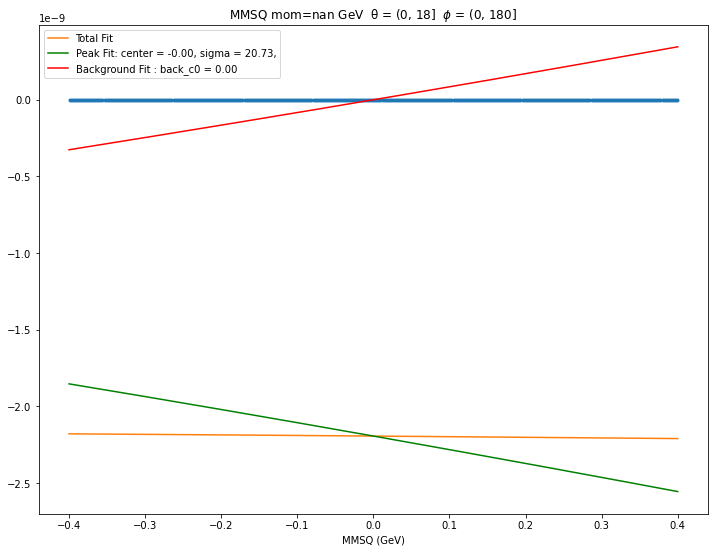

total =  -1.1410444286074486e-07
signal =  -1.1454663281853352e-07
background =  4.4218995778866604e-10
ratio =  -259.0439488751988


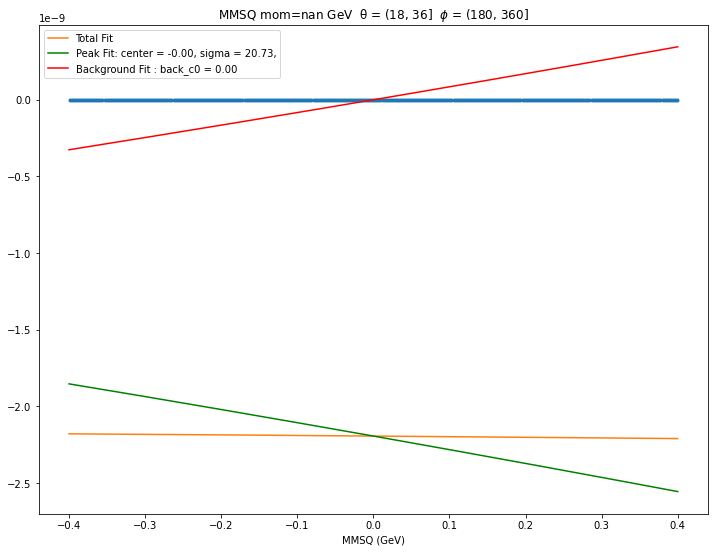

total =  -1.1410444286074486e-07
signal =  -1.1454663281853352e-07
background =  4.4218995778866604e-10
ratio =  -259.0439488751988


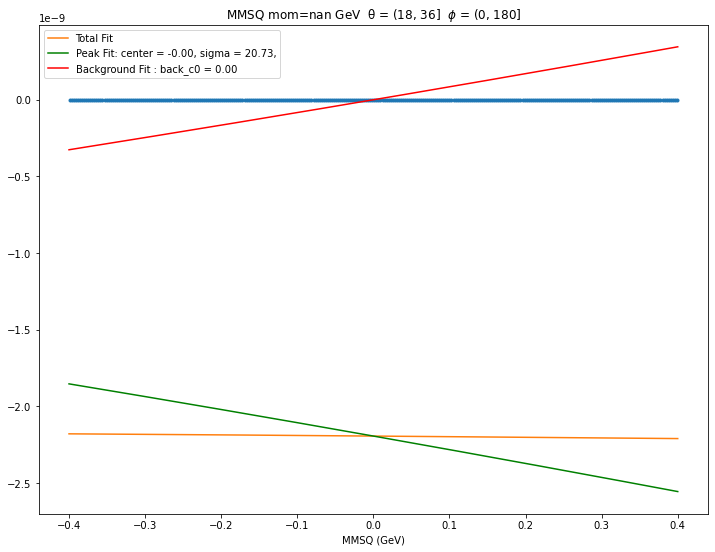

total =  -1.1410444286074486e-07
signal =  -1.1454663281853352e-07
background =  4.4218995778866604e-10
ratio =  -259.0439488751988


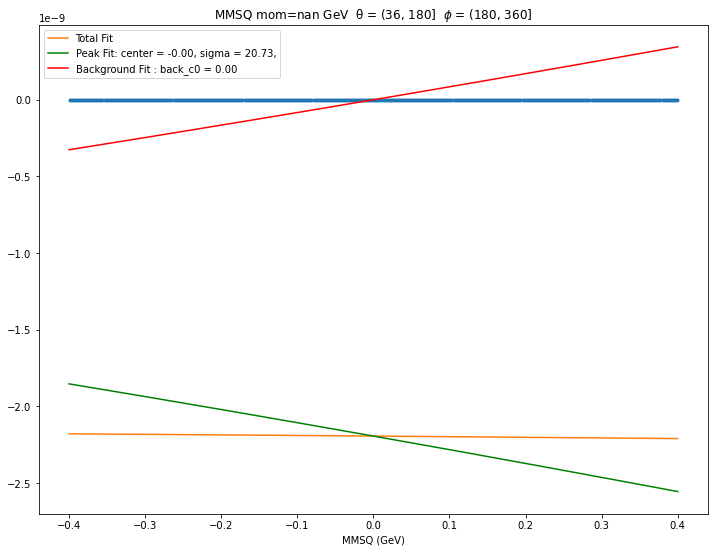

total =  -1.1410444286074486e-07
signal =  -1.1454663281853352e-07
background =  4.4218995778866604e-10
ratio =  -259.0439488751988


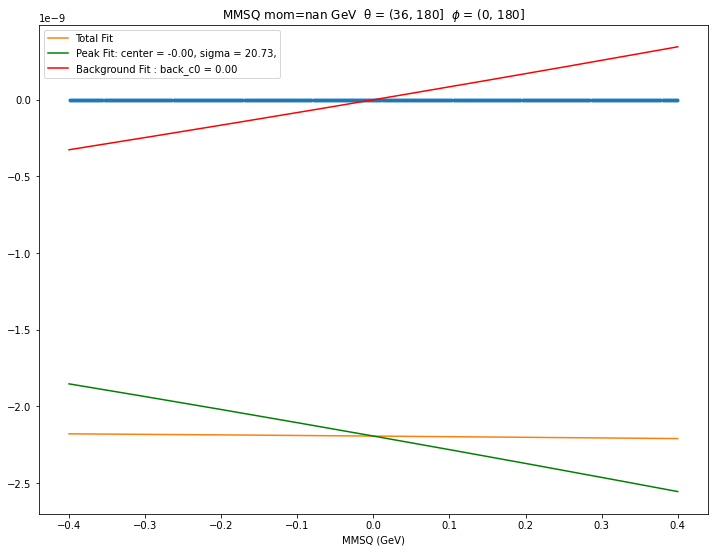

In [29]:
sector_cuts = mm_cut(rec)